# Модель обработки тревог самокатов v4

In [205]:
import os
import sys
from pathlib import Path
ROOT_DIR = Path.cwd().parent
if str(ROOT_DIR) not in sys.path:
    sys.path.append(str(ROOT_DIR))
    
from config import DB_URI
from sqlalchemy import create_engine, text
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import optuna
import gc

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, fbeta_score, precision_score, recall_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from xgboost import XGBClassifier, plot_importance
from xgboost.callback import EarlyStopping
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import time
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score, average_precision_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import shap

sns.set(style="whitegrid", rc={"figure.figsize": (8, 6)})


In [2]:
engine = create_engine(DB_URI)

In [3]:
with engine.connect() as conn:
    total = conn.execute(text("SELECT COUNT(*) FROM incidents")).scalar()

## Загрузка данных из бд

In [19]:
batch_size = 5000
offset = 0
rows = []

with engine.connect() as conn, tqdm(total=total, desc="Загрузка данных", unit="строк") as pbar:
    while True:
        query = f"""
            SELECT 
                mf.*, 
                i.business_status, i.incident_created_at AS incident_incident_created_at, i.identifier, i.alarm_id,
                mpf.is_weak_motion, mpf.is_slow_progress, mpf.is_circular_motion, mpf.is_no_motion,
                rf.looks_like_rent, rf.moved_without_rent, rf.moved_immediately_after_rent,
                rf.returned_to_access_5min, rf.had_rent_last_2h, rf.end_is_start,
                tf.is_night_alarm, tf.alarm_delay_seconds, tf.alarm_hour,
                zf.was_in_tech_zone_before_alarm, zf.was_in_restricted_zone_before_alarm,
                gqf.valid_coord_ratio, gqf.average_satellites, gqf.average_rssi, gqf.unstable_gps_jumps, gqf.detected_jumps,
                oc.*
            FROM movement_features mf
            LEFT JOIN incidents i ON mf.incident_id = i.id
            LEFT JOIN motion_pattern_features mpf ON mf.incident_id = mpf.incident_id
            LEFT JOIN rental_features rf ON mf.incident_id = rf.incident_id
            LEFT JOIN time_features tf ON mf.incident_id = tf.incident_id
            LEFT JOIN zone_features zf ON mf.incident_id = zf.incident_id
            LEFT JOIN gps_quality_features gqf ON mf.incident_id = gqf.incident_id
            LEFT JOIN operator_comments oc ON mf.incident_id = oc.incident_id
            ORDER BY mf.id
            OFFSET {offset} LIMIT {batch_size}
        """
        batch = pd.read_sql_query(text(query), conn)

        if batch.empty:
            break

        rows.append(batch)
        offset += batch_size
        pbar.update(len(batch))

df = pd.concat(rows, ignore_index=True)


Загрузка данных: 412787строк [07:12, 954.11строк/s]                                                                                                                              
/tmp/ipykernel_30825/2192580766.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(rows, ignore_index=True)
/tmp/ipykernel_30825/2192580766.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(rows, ignore_index=True)


In [20]:
df.columns

Index(['id', 'incident_id', 'max_speed_kmh', 'mean_speed_kmh',
       'median_speed_kmh', 'is_too_fast_speed', 'is_too_fast_trip',
       'gps_jumps_count', 'is_only_linear_segments', 'is_zigzag',
       'is_back_and_forth', 'is_highly_linear', 'has_long_stop',
       'total_distance', 'track_point_count',
       'linear_segments_with_low_satellites', 'has_local_confused_movement',
       'is_far_zigzag', 'is_far_back_and_forth', 'business_status',
       'incident_created_at', 'identifier', 'alarm_id', 'is_weak_motion',
       'is_slow_progress', 'is_circular_motion', 'is_no_motion',
       'looks_like_rent', 'moved_without_rent', 'moved_immediately_after_rent',
       'returned_to_access_5min', 'had_rent_last_2h', 'end_is_start',
       'is_night_alarm', 'alarm_delay_seconds', 'alarm_hour',
       'was_in_tech_zone_before_alarm', 'was_in_restricted_zone_before_alarm',
       'valid_coord_ratio', 'average_satellites', 'average_rssi',
       'unstable_gps_jumps', 'detected_jumps', 'id'

In [22]:
df.to_csv('../data/raw_dataset_1_05.csv')

In [88]:
df = pd.read_csv('../data/raw_dataset_1_05.csv')

/tmp/ipykernel_61690/2332281594.py:1: DtypeWarning: Columns (17,18,19,28,31,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/raw_dataset_1_05.csv')


## EDA + data preprocessing

### Distributions lookup

In [5]:
nan_summary = df.isnull().sum().to_frame(name='missing_count')
nan_summary['missing_percent'] = (nan_summary['missing_count'] / len(df)) * 100

nan_summary = nan_summary.sort_values(by='missing_count', ascending=False)

print(nan_summary)

                                     missing_count  missing_percent
gps_jumps_count                             412787       100.000000
business_status                             392088        94.985549
needs_repair                                363002        87.939300
gps_error                                   363002        87.939300
comment                                     363002        87.939300
no_connection                               363002        87.939300
awaiting_service                            363002        87.939300
rent_blocked                                363002        87.939300
returned_to_access                          363002        87.939300
alarm_movement                              363002        87.939300
outside_zone                                363002        87.939300
low_battery                                 363002        87.939300
created_at                                  233252        56.506624
has_local_confused_movement                  390

Всего object-фич под анализ: 34 → ['is_too_fast_speed', 'is_too_fast_trip', 'is_only_linear_segments', 'is_zigzag', 'is_back_and_forth', 'is_highly_linear', 'has_long_stop', 'has_local_confused_movement', 'is_far_zigzag', 'is_far_back_and_forth', 'business_status', 'is_weak_motion', 'is_slow_progress', 'is_circular_motion', 'is_no_motion', 'looks_like_rent', 'moved_without_rent', 'moved_immediately_after_rent', 'returned_to_access_5min', 'had_rent_last_2h', 'end_is_start', 'is_night_alarm', 'was_in_tech_zone_before_alarm', 'was_in_restricted_zone_before_alarm', 'low_battery', 'needs_repair', 'gps_error', 'outside_zone', 'alarm_movement', 'returned_to_access', 'rent_blocked', 'awaiting_service', 'no_connection', 'comment']

=== is_too_fast_speed ===


,count
is_too_fast_speed,
True,290398
False,121394
NaN,995


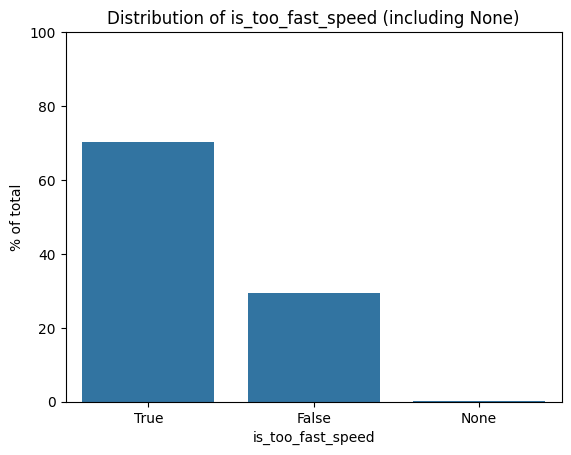


=== is_too_fast_trip ===


,count
is_too_fast_trip,
True,248738
False,163054
NaN,995


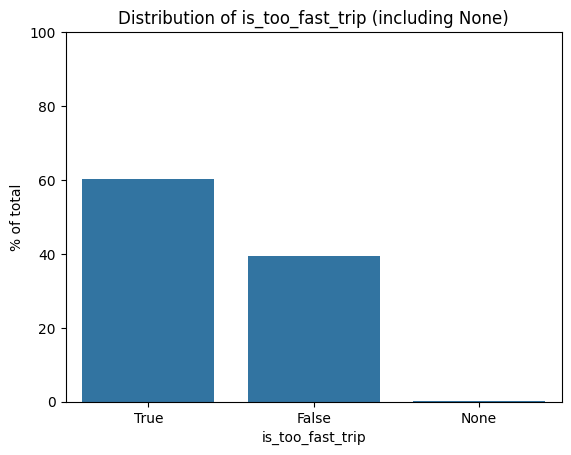


=== is_only_linear_segments ===


,count
is_only_linear_segments,
False,266934
True,144860
NaN,993


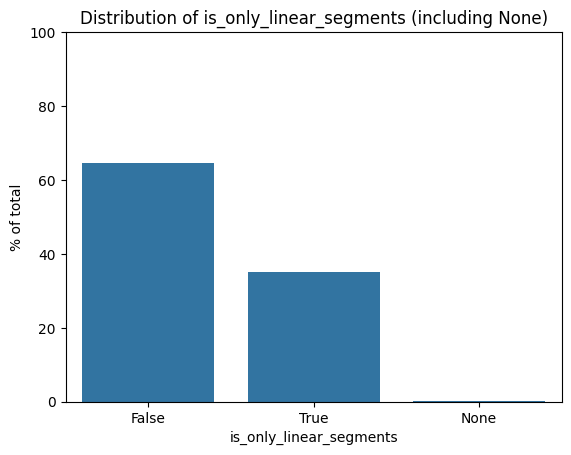


=== is_zigzag ===


,count
is_zigzag,
True,295935
False,114141
NaN,2711


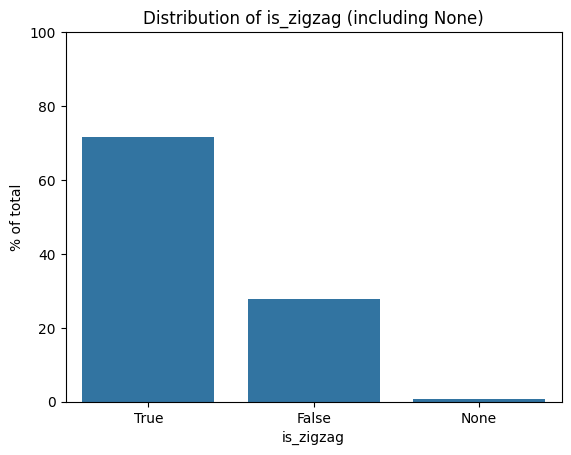


=== is_back_and_forth ===


,count
is_back_and_forth,
True,319364
False,88232
NaN,5191


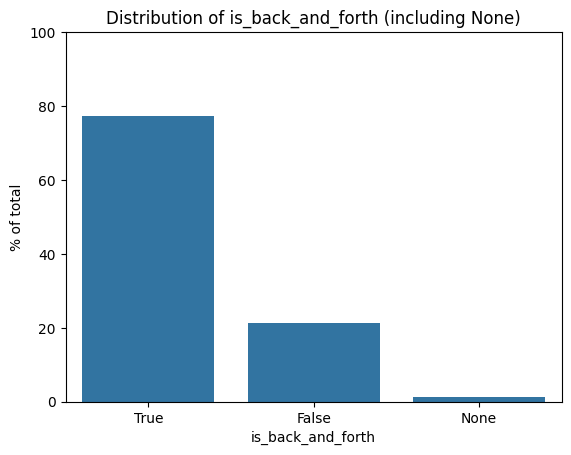


=== is_highly_linear ===


,count
is_highly_linear,
False,379645
True,32149
NaN,993


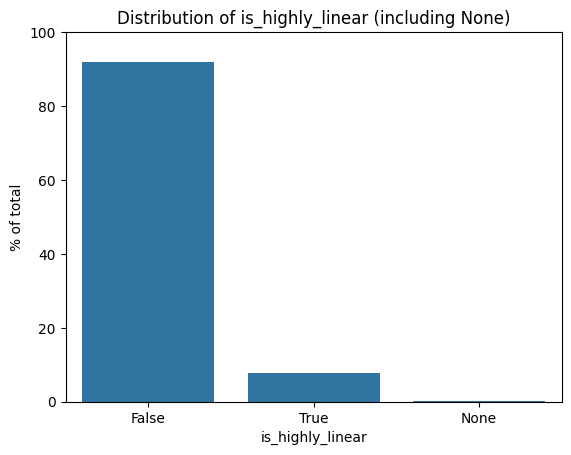


=== has_long_stop ===


,count
has_long_stop,
True,393376
False,18418
NaN,993


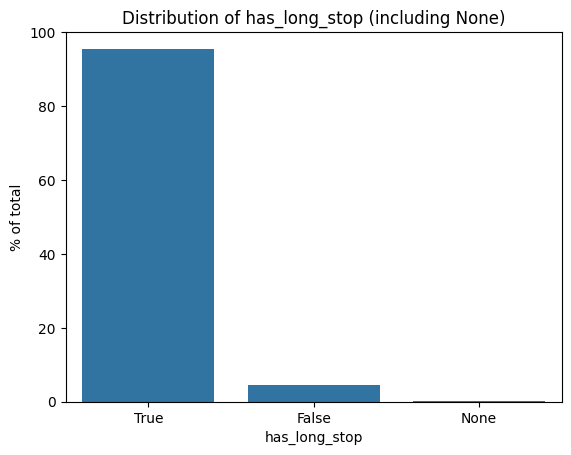


=== has_local_confused_movement ===


,count
has_local_confused_movement,
True,236908
False,136781
NaN,39098


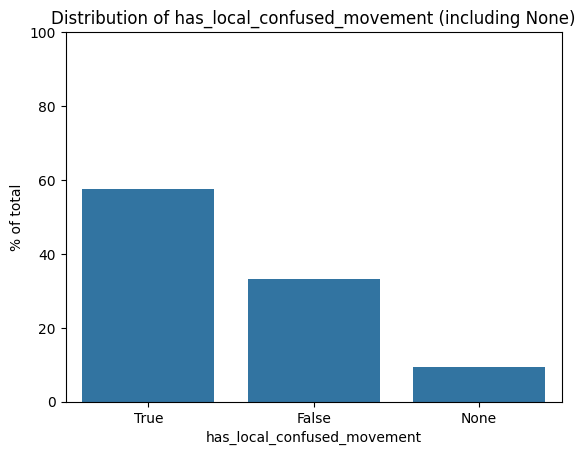


=== is_far_zigzag ===


,count
is_far_zigzag,
False,211342
True,164615
NaN,36830


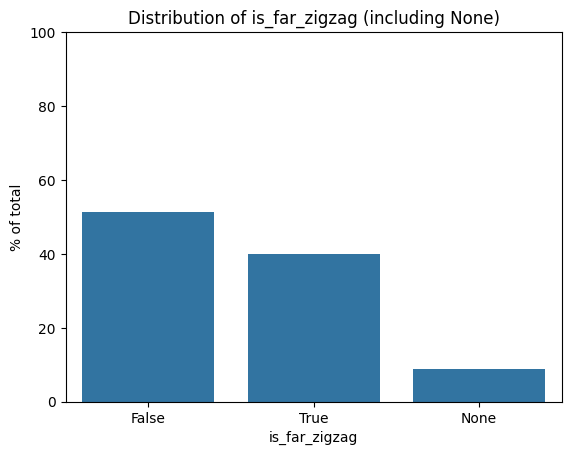


=== is_far_back_and_forth ===


,count
is_far_back_and_forth,
True,266891
False,106798
NaN,39098


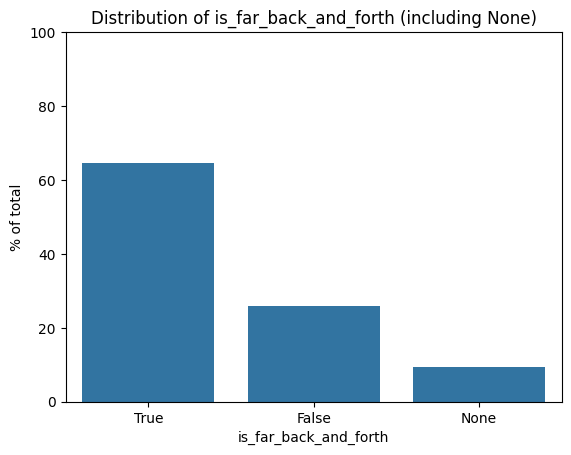


=== business_status ===


,count
business_status,
NaN,392088
Investigation,20699


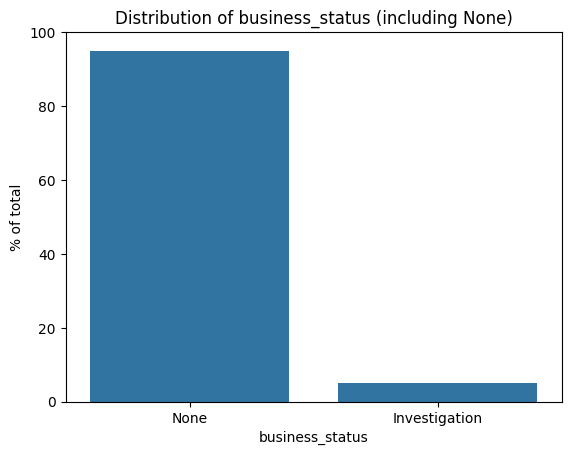


=== is_weak_motion ===


,count
is_weak_motion,
False,353567
True,57671
NaN,1549


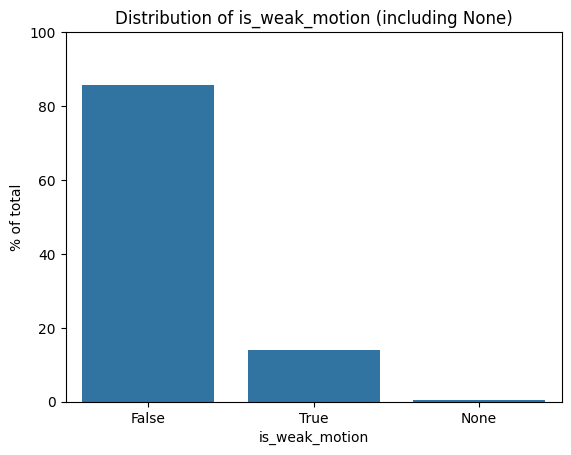


=== is_slow_progress ===


,count
is_slow_progress,
False,340023
True,71215
NaN,1549


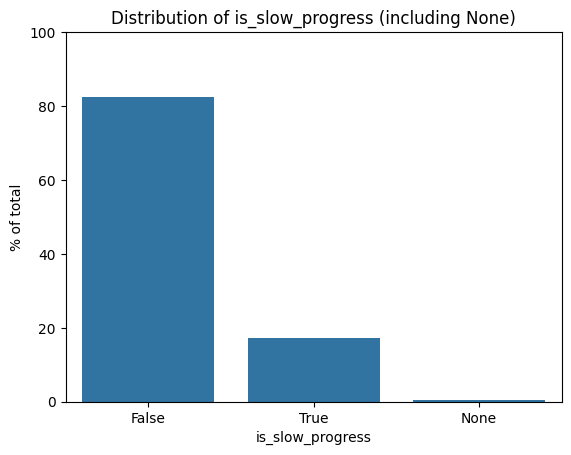


=== is_circular_motion ===


,count
is_circular_motion,
True,242282
False,133360
NaN,37145


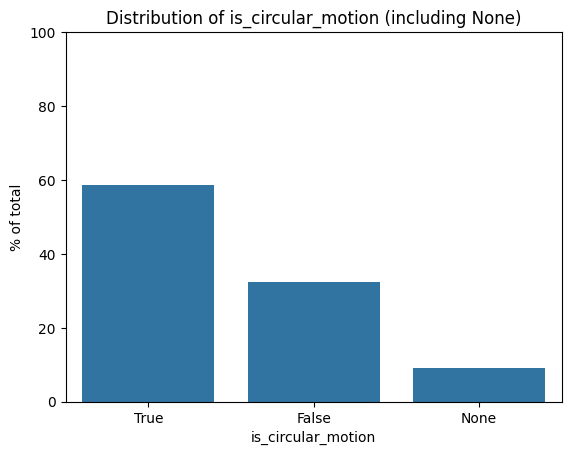


=== is_no_motion ===


,count
is_no_motion,
False,365208
True,46030
NaN,1549


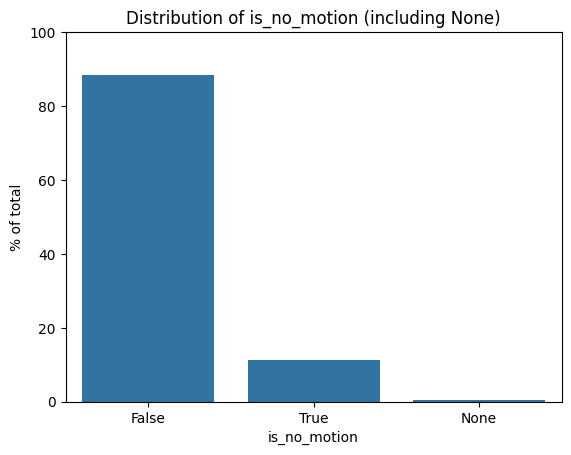


=== looks_like_rent ===


,count
looks_like_rent,
False,377754
True,34162
NaN,871


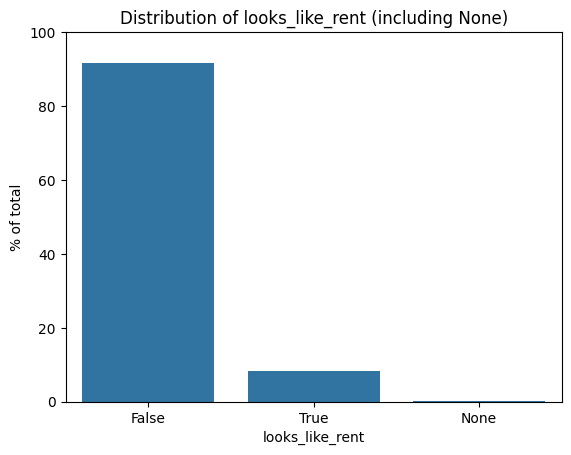


=== moved_without_rent ===


,count
moved_without_rent,
True,348099
False,63138
NaN,1550


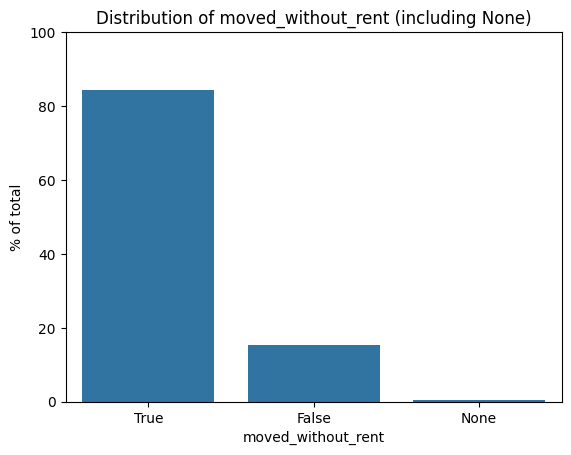


=== moved_immediately_after_rent ===


,count
moved_immediately_after_rent,
False,295968
True,107131
NaN,9688


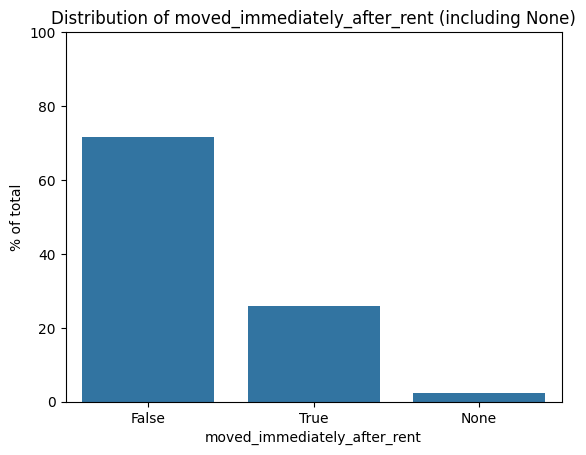


=== returned_to_access_5min ===


,count
returned_to_access_5min,
False,354404
True,53217
NaN,5166


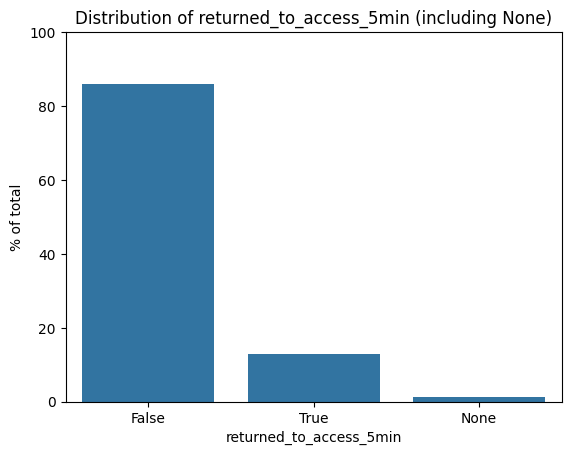


=== had_rent_last_2h ===


,count
had_rent_last_2h,
False,296405
True,111216
NaN,5166


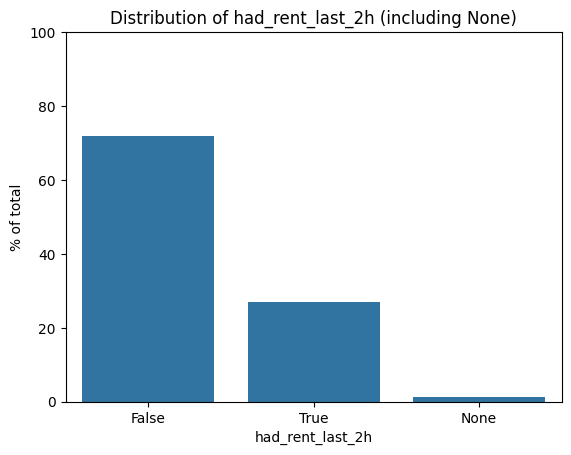


=== end_is_start ===


,count
end_is_start,
False,326906
True,84332
NaN,1549


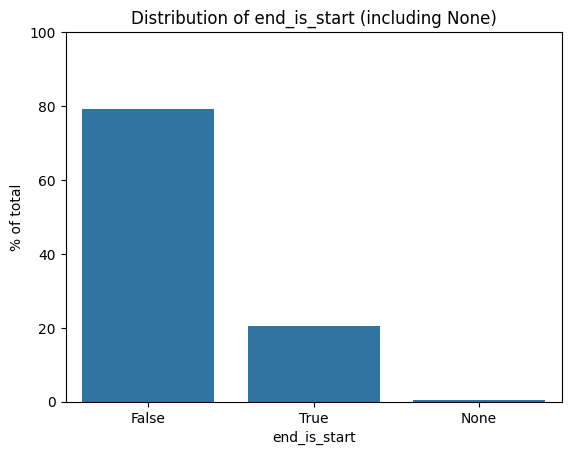


=== is_night_alarm ===


,count
is_night_alarm,
False,288264
True,123643
NaN,880


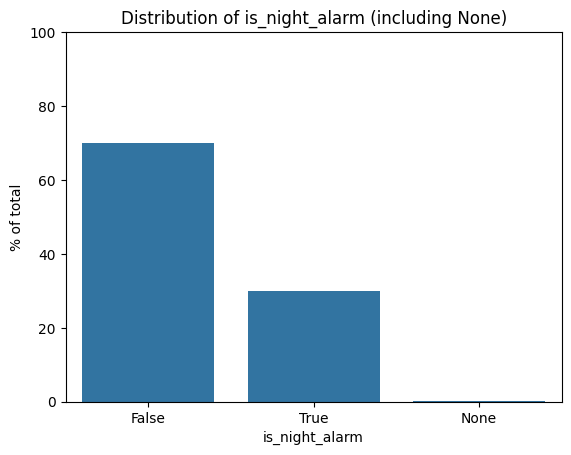


=== was_in_tech_zone_before_alarm ===


,count
was_in_tech_zone_before_alarm,
True,245023
False,141045
NaN,26719


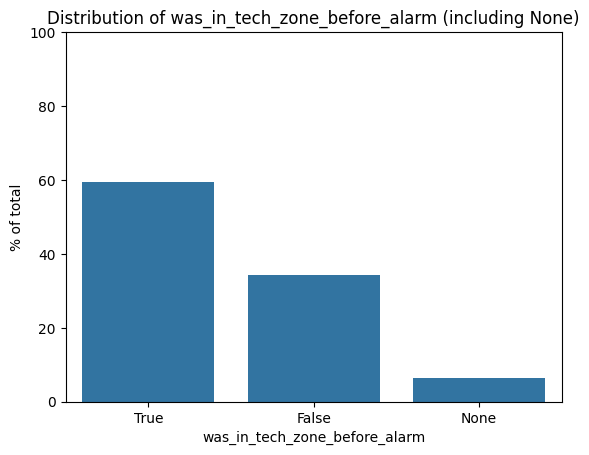


=== was_in_restricted_zone_before_alarm ===


,count
was_in_restricted_zone_before_alarm,
False,373580
NaN,26719
True,12488


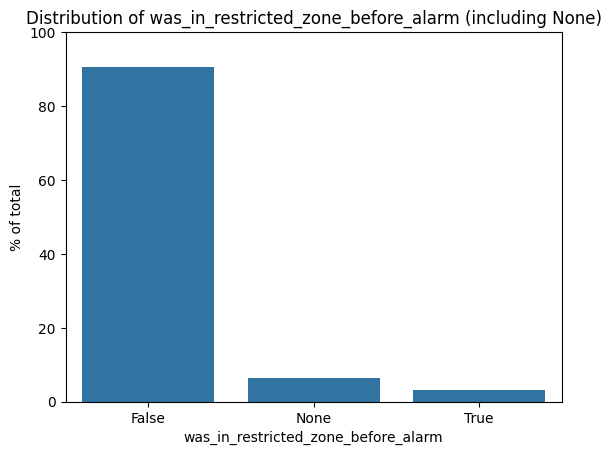


=== low_battery ===


,count
low_battery,
NaN,363002
False,37572
True,12213


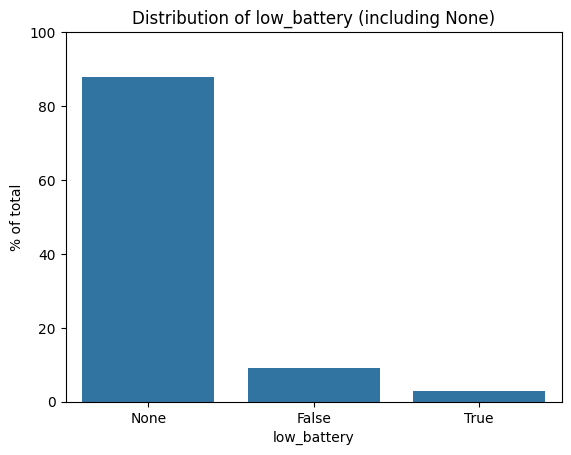


=== needs_repair ===


,count
needs_repair,
NaN,363002
False,47478
True,2307


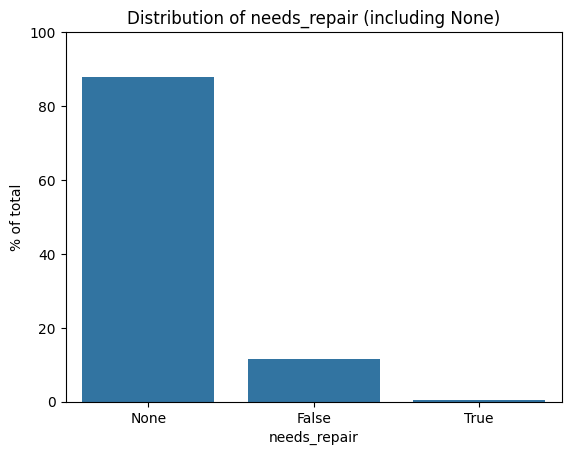


=== gps_error ===


,count
gps_error,
NaN,363002
False,49734
True,51


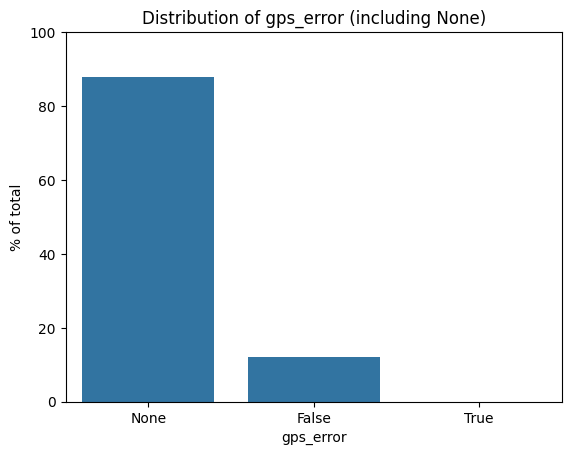


=== outside_zone ===


,count
outside_zone,
NaN,363002
False,49190
True,595


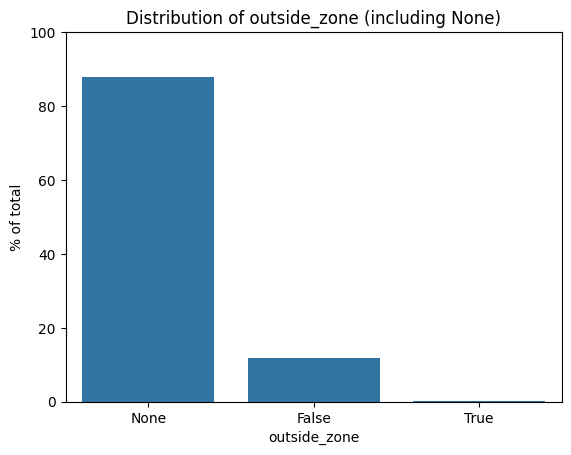


=== alarm_movement ===


,count
alarm_movement,
NaN,363002
False,27097
True,22688


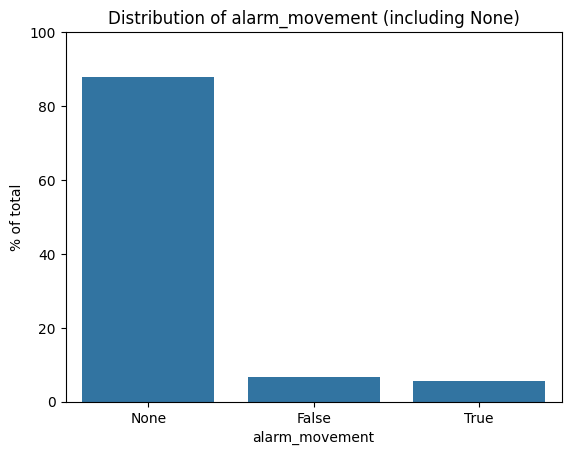


=== returned_to_access ===


,count
returned_to_access,
NaN,363002
True,35713
False,14072


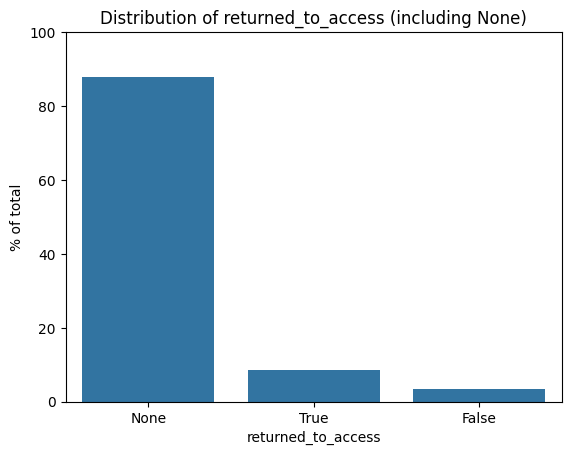


=== rent_blocked ===


,count
rent_blocked,
NaN,363002
False,48822
True,963


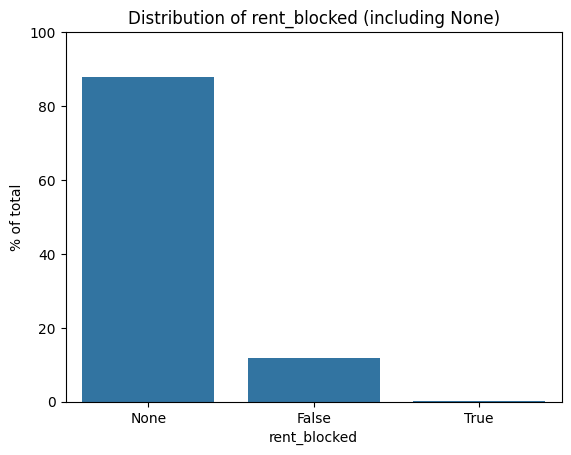


=== awaiting_service ===


,count
awaiting_service,
NaN,363002
False,47665
True,2120


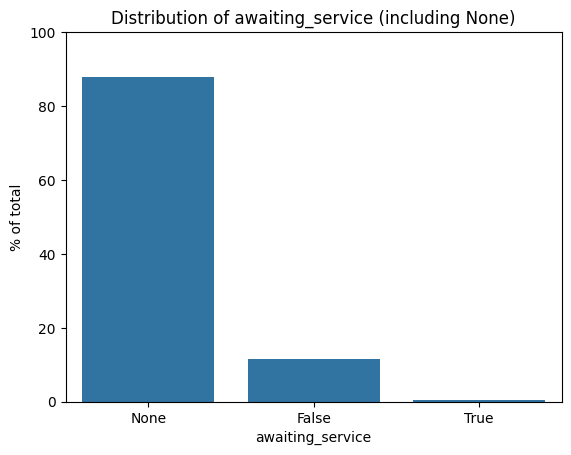


=== no_connection ===


,count
no_connection,
NaN,363002
False,49768
True,17


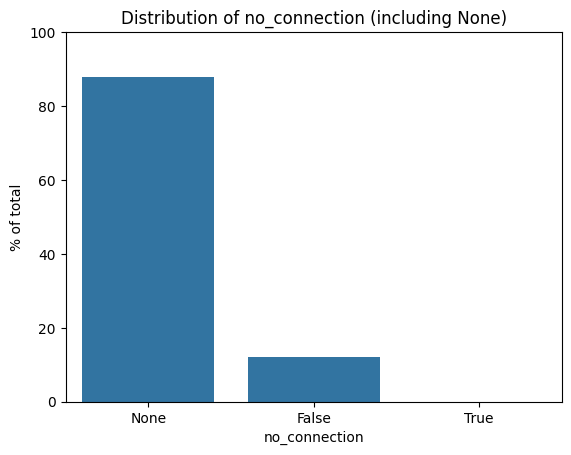


=== comment ===


,count
comment,
NaN,363002
Возвращение в доступ,8932
LowBattery,8844
Перемещение. Service Lease Возвращение в доступ,3627
Перемещение. Перемещение Возвращение в доступ,3419
...,...
Тревога. Движение без аренды Public access activated Тревога. Движение без аренды Public access activated Тревога. Движение без аренды,1
Возвращение в доступ Требует ремонта Waiting for the SC repair,1
Требует ремонта Перемещение. Service Lease Перемещение. Service Lease Возвращение в доступ,1


/home/kdankova/jet_alerts/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/kdankova/jet_alerts/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9940 (\N{NO ENTRY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


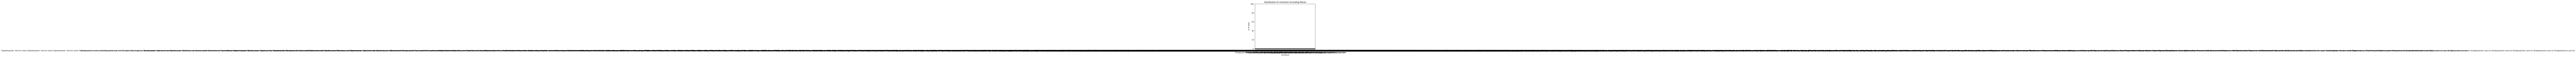

In [7]:
exclude_cols = ['alarm_hour', 'incident_incident_created_at', 'identifier', 'alarm_id', 'incident_created_at']
obj_indicator_cols = [
    c for c in df.select_dtypes(include='object').columns
    if c not in exclude_cols
]

print(f'Всего object-фич под анализ: {len(obj_indicator_cols)} → {obj_indicator_cols}')

for col in obj_indicator_cols:
    print(f'\n=== {col} ===')
    display(df[col].value_counts(dropna=False).to_frame('count'))
    
    plot_data = (
        df[col]
        .fillna('None')
        .value_counts(normalize=True)
        .mul(100)
        .rename_axis(col)
        .reset_index(name='pct')
    )
    
    sns.barplot(x=col, y='pct', data=plot_data)
    plt.ylabel('% of total')
    plt.title(f'Distribution of {col} (including None)')
    plt.ylim(0, 100)
    plt.show()


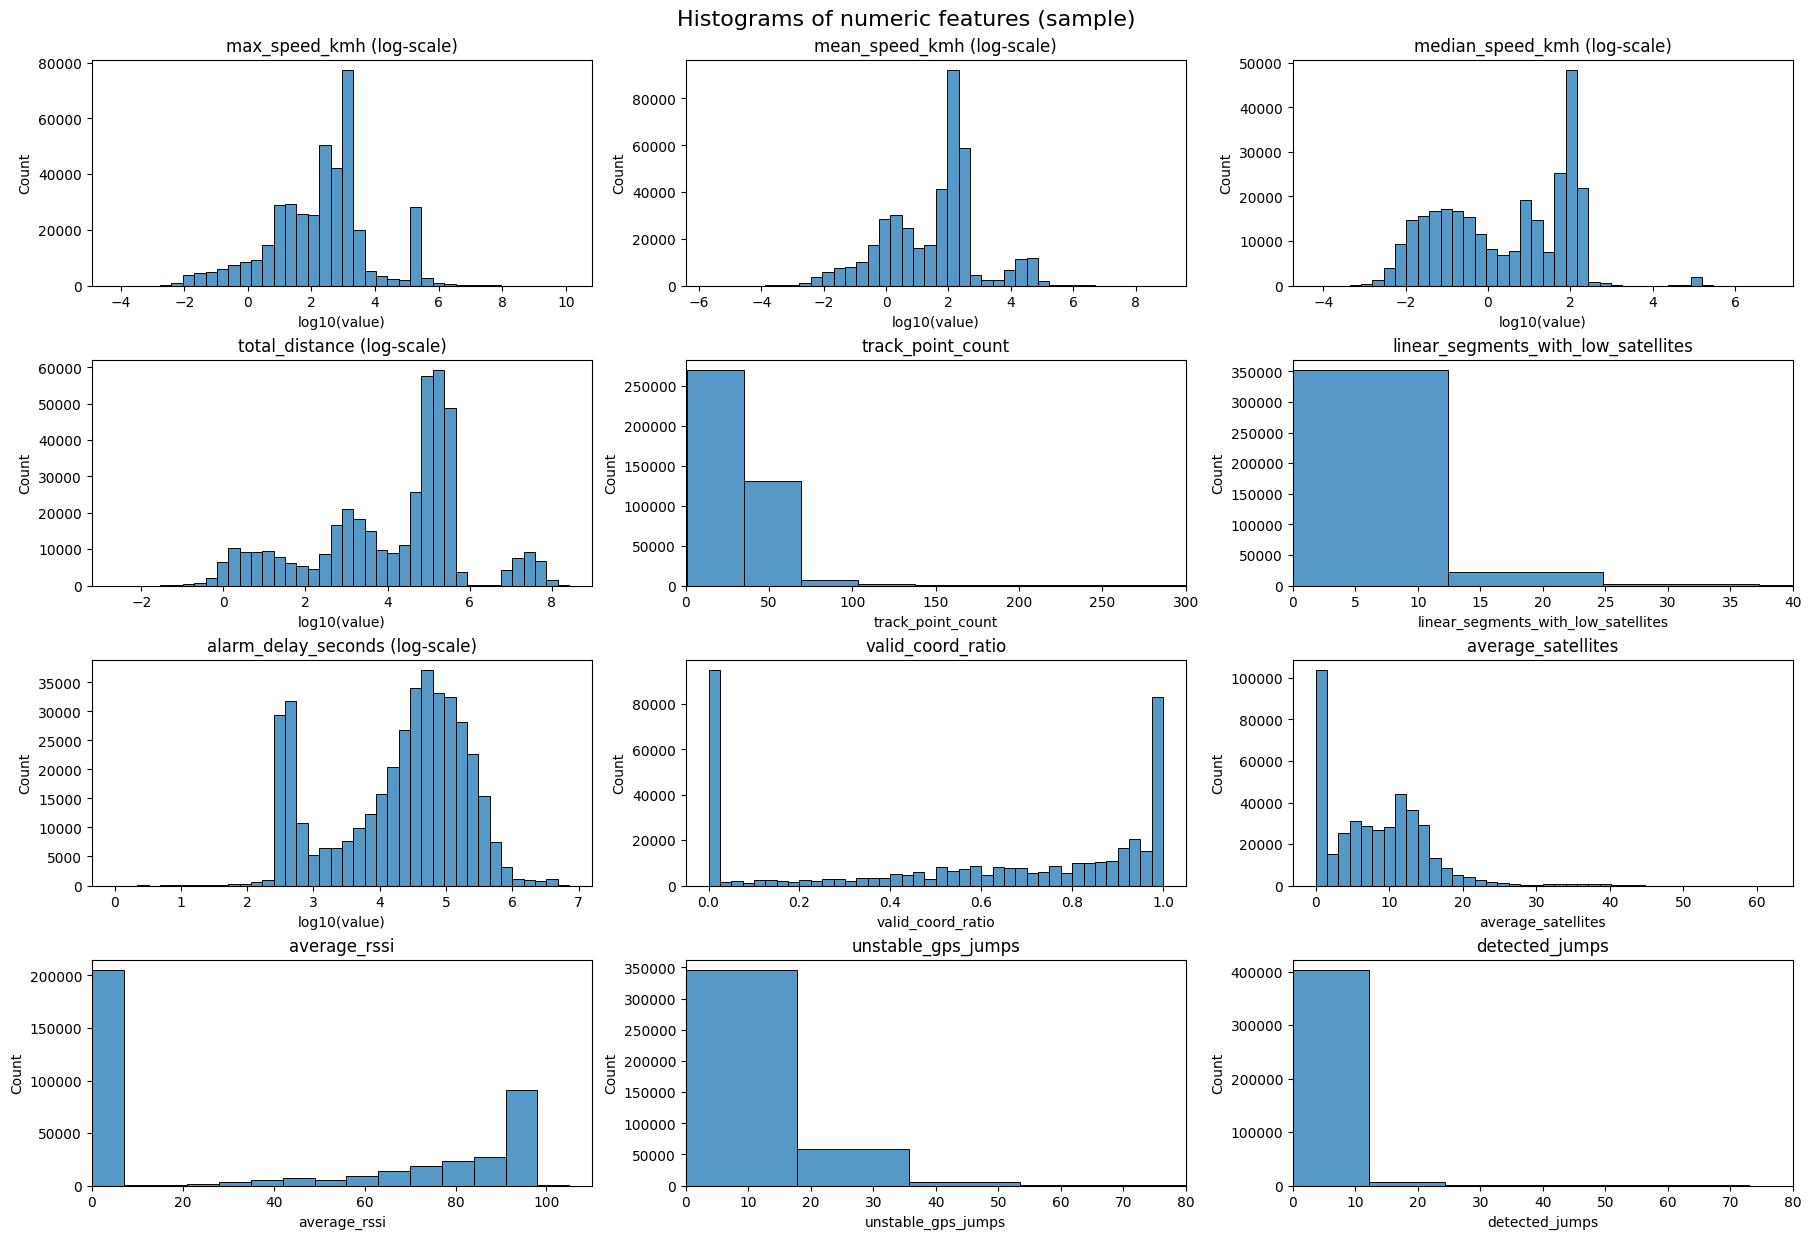

In [21]:
import math, numpy as np
import seaborn as sns, matplotlib.pyplot as plt

id_like  = ['id', 'incident_id', 'id.1', 'incident_id.1',
            'Unnamed: 0', 'gps_jumps_count']
num_cols = [c for c in df.select_dtypes('number').columns if c not in id_like]

log_cols = {
    'max_speed_kmh',
    'mean_speed_kmh',
    'median_speed_kmh',
    'total_distance',
    'alarm_delay_seconds'
}

xlims_lin = {
    'track_point_count'                : (0, 300),
    'linear_segments_with_low_satellites': (0, 40),
    'average_rssi'                     : (0, 110),
    'unstable_gps_jumps'               : (0, 80),
    'detected_jumps'                   : (0, 80)
}

n_cols, n_rows = 3, math.ceil(len(num_cols) / 3)
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(6 * n_cols, 3 * n_rows),
    constrained_layout=True
)
axes = axes.flatten()

for ax, col in zip(axes, num_cols):
    data = df[col].dropna()

    if col in log_cols:
        data = data[data > 0]
        sns.histplot(np.log10(data), bins=40, ax=ax)
        ax.set_xlabel('log10(value)')
        ax.set_title(f'{col} (log-scale)')
    else:
        sns.histplot(data, bins=40, ax=ax)
        ax.set_title(col)
        if col in xlims_lin:
            ax.set_xlim(xlims_lin[col])

for ax in axes[len(num_cols):]:
    ax.set_visible(False)

fig.suptitle('Histograms of numeric features (sample)', fontsize=16, y=1.02)
plt.show()


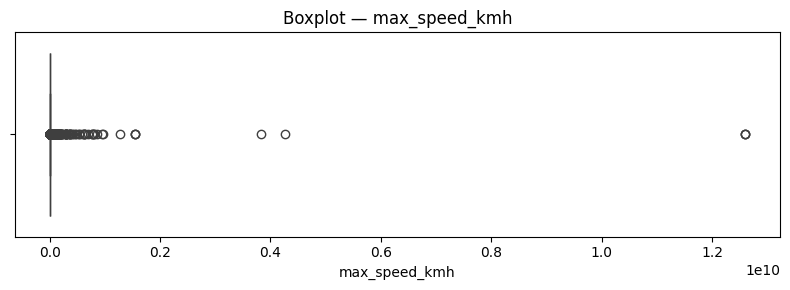

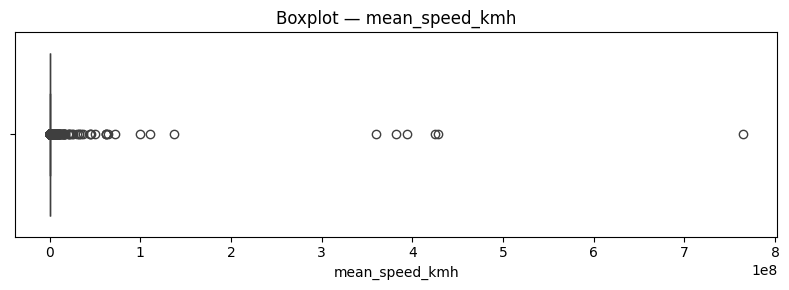

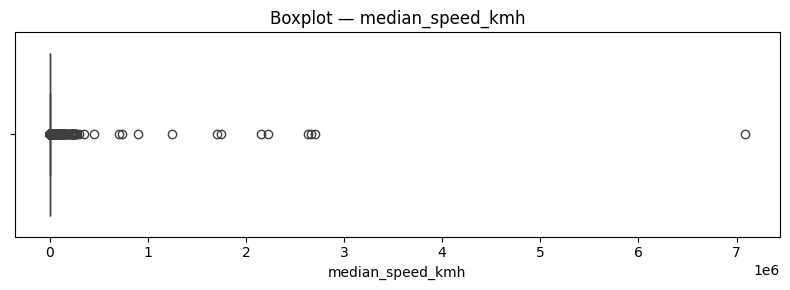

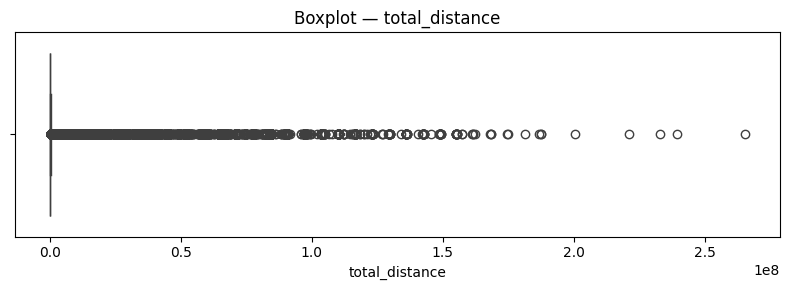

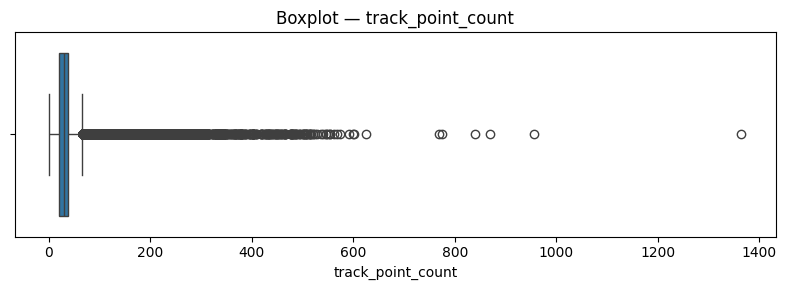

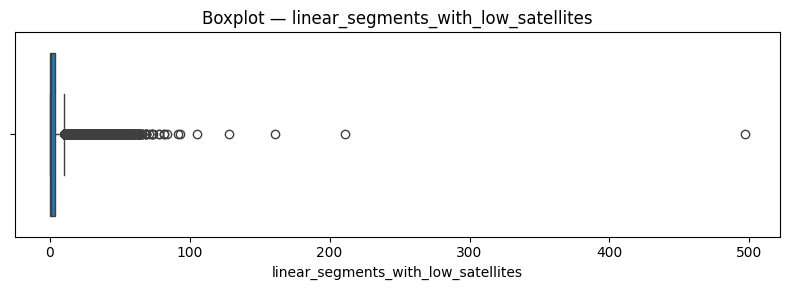

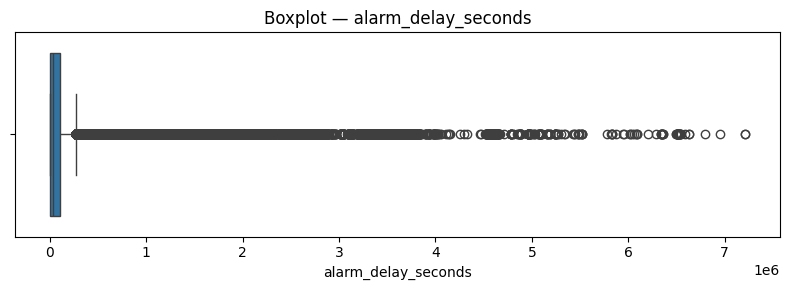

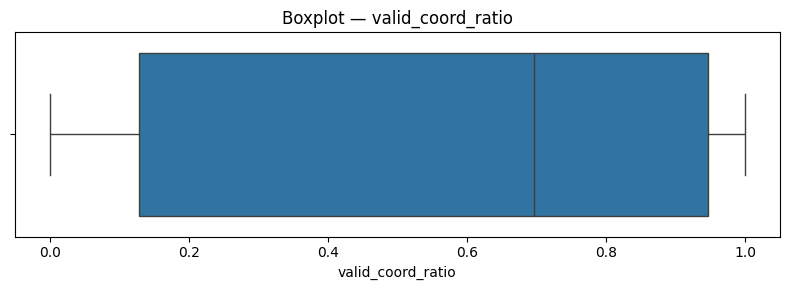

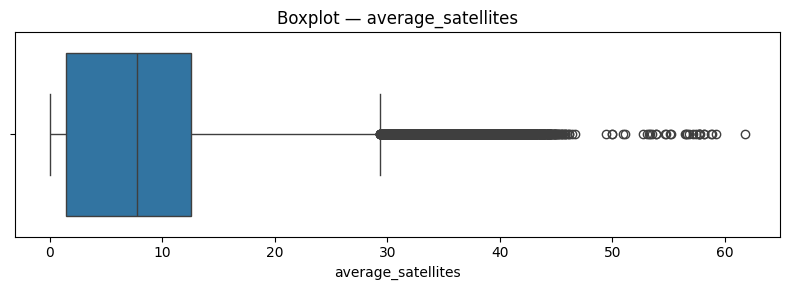

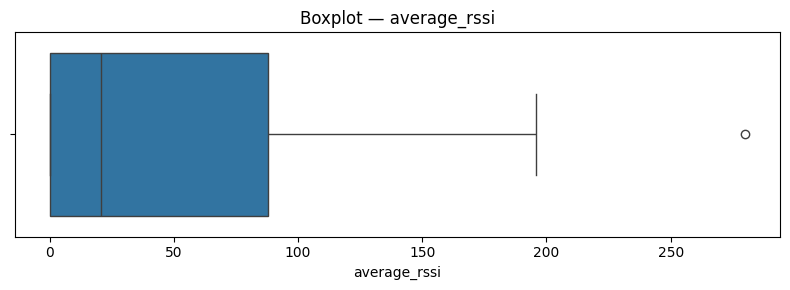

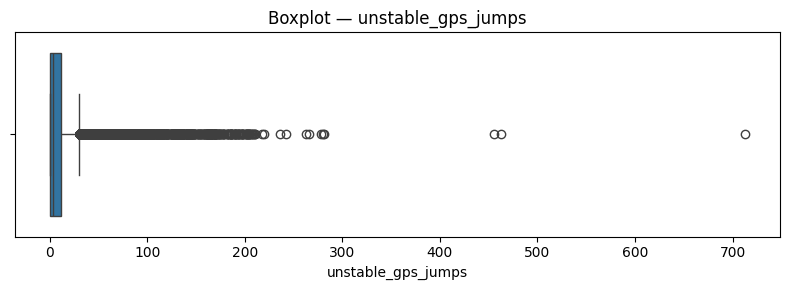

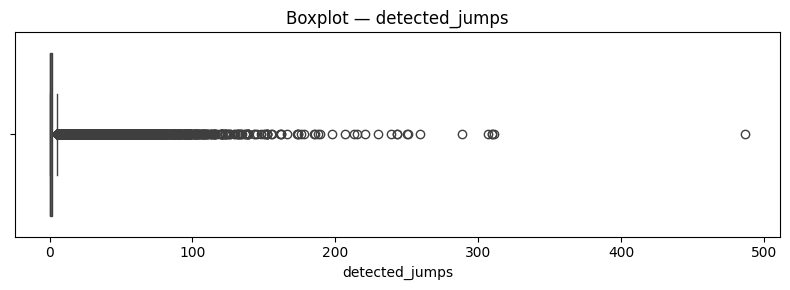

In [58]:
for col in num_cols:
    if df[col].nunique(dropna=True) <= 1:
        continue

    plt.figure(figsize=(8, 3))
    sns.boxplot(x=df[col].dropna(), orient='h')
    plt.title(f'Boxplot — {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

In [30]:
for col in num_cols:
    print(f'\n── {col} ──')
    print(df[col].describe())


── max_speed_kmh ──
count    4.117920e+05
mean     2.270172e+05
std      3.587849e+07
min      0.000000e+00
25%      1.776653e+01
50%      3.091117e+02
75%      1.506383e+03
max      1.260302e+10
Name: max_speed_kmh, dtype: float64

── mean_speed_kmh ──
count    4.117920e+05
mean     1.469535e+04
std      1.886143e+06
min      0.000000e+00
25%      1.959186e+00
50%      7.370326e+01
75%      2.065041e+02
max      7.643891e+08
Name: mean_speed_kmh, dtype: float64

── median_speed_kmh ──
count    4.117920e+05
mean     7.667669e+02
std      1.758381e+04
min      0.000000e+00
25%      0.000000e+00
50%      1.410987e-01
75%      2.853159e+01
max      7.088354e+06
Name: median_speed_kmh, dtype: float64

── total_distance ──
count    4.117940e+05
mean     2.339634e+06
std      1.005835e+07
min      0.000000e+00
25%      7.613945e+02
50%      5.841409e+04
75%      1.691407e+05
max      2.652902e+08
Name: total_distance, dtype: float64

── track_point_count ──
count    411794.000000
mean      

Булевых признаков: 1 → ['flag']


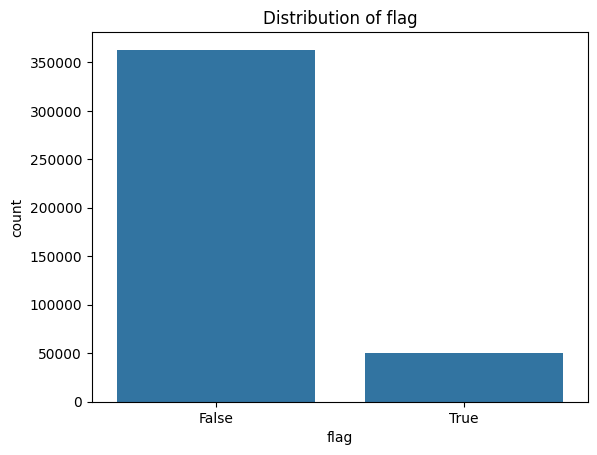

In [4]:
bool_cols = df.select_dtypes(include='bool').columns
print(f'Булевых признаков: {len(bool_cols)} → {list(bool_cols)}')

for col in bool_cols:
    vc = df[col].value_counts(dropna=False).rename_axis(col).reset_index(name='count')
    vc[col] = vc[col].astype(str)

    sns.barplot(x=col, y='count', data=vc)
    plt.title(f'Distribution of {col}')
    plt.ylabel('count')
    plt.show()

### NaN preprocessing

In [89]:
drop_cols = ['gps_jumps_count', 'created_at', 'comment', 'id', 'id.1', 'incident_id.1']
df = df.drop(columns=drop_cols)

Всего строк с NaN в has_local_confused_movement: 39,098


,track_point_count_when_NaN
count,38105.000000
mean,26.940874
std,26.639497
min,1.000000
25%,8.000000
50%,29.000000
75%,36.000000
90%,43.000000
99%,111.000000
max,524.000000


,rows,percent
track_point_count,,
"[0.0, 1.0)",0,0.000000
"[1.0, 2.0)",1718,4.394087
"[2.0, 5.0)",5299,13.553123
"[5.0, 10.0)",3170,8.107832
"[10.0, 20.0)",3687,9.430150
"[20.0, 50.0)",21782,55.711290
"[50.0, inf)",2449,6.263748


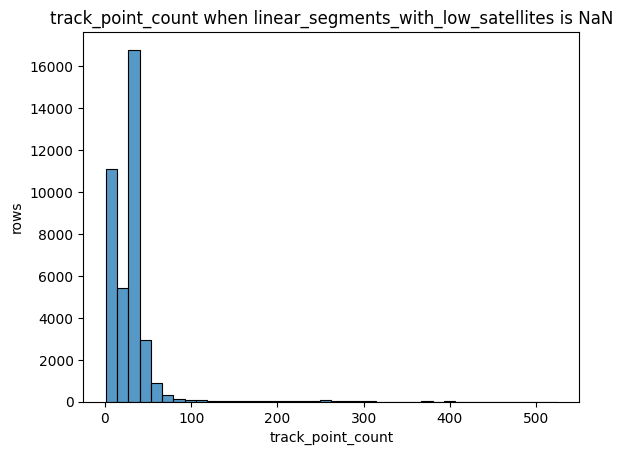

In [43]:
col = 'has_local_confused_movement'
mask_nan = df[col].isna()                       

print(f'Всего строк с NaN в {col}: {mask_nan.sum():,}')

# 1) Смотрим, сколько у них track_point_count
tp_stats = (
    df.loc[mask_nan, 'track_point_count']
      .describe(percentiles=[.25,.5,.75,.9,.99])
      .to_frame('track_point_count_when_NaN')
)
display(tp_stats)

# 2) Насколько короткий трек?
bins = [0, 1, 2, 5, 10, 20, 50, np.inf]
tp_hist = (
    pd.cut(df.loc[mask_nan, 'track_point_count'], bins=bins, right=False)
      .value_counts()
      .sort_index()
      .to_frame('rows')
)
tp_hist['percent'] = tp_hist['rows'] / mask_nan.sum() * 100
display(tp_hist)

# 3) Быстрый график
import seaborn as sns, matplotlib.pyplot as plt
sns.histplot(df.loc[mask_nan, 'track_point_count'], bins=40)
plt.title('track_point_count when linear_segments_with_low_satellites is NaN')
plt.xlabel('track_point_count'); plt.ylabel('rows')
plt.show()


In [90]:
# Флаги-события: «нет данных» ≈ «события не было»  →  NaN → 0
zero_fill_cols = [
    'needs_repair','gps_error','no_connection','awaiting_service',
    'rent_blocked','returned_to_access','alarm_movement','outside_zone',
    'low_battery','moved_immediately_after_rent','had_rent_last_2h',
    'returned_to_access_5min','moved_without_rent','is_back_and_forth',
    'is_zigzag','is_no_motion','end_is_start','is_weak_motion',
    'is_slow_progress','is_night_alarm','looks_like_rent',
    'was_in_restricted_zone_before_alarm','was_in_tech_zone_before_alarm',
    'is_circular_motion'
]
df[zero_fill_cols] = df[zero_fill_cols].fillna(0).astype(int)

# Track-quality признаки — NaN информативен ➜ оставляем, + индикатор
track_flags = [
    'has_local_confused_movement','is_far_back_and_forth',
    'is_far_zigzag','linear_segments_with_low_satellites'
]

# alarm_delay_seconds : NaN → 0  + индикатор
df['alarm_delay_seconds_missing'] = df['alarm_delay_seconds'].isna().astype(int)
df['alarm_delay_seconds']         = df['alarm_delay_seconds'].fillna(0)

# Median-импутация для числовых, где это безопасно (<3 % NaN, узкий диапазон)
safe_median = [
    'average_rssi','average_satellites','valid_coord_ratio','track_point_count',
    # добавлены «узкие» колонки с NaN≈0.24 %
    'has_long_stop','is_highly_linear','is_only_linear_segments',
    'is_too_fast_speed','is_too_fast_trip'
]
for c in safe_median:
    df[c] = df[c].fillna(df[c].median())

# Числовые, где NaN сам по себе информативен (добавляем индикаторы)
df['mean_speed_kmh' + '_missing'] = df['mean_speed_kmh'].isna().astype(int)


In [91]:
df['alarm_hour'] = df['alarm_hour'].astype(str)
df['alarm_hour'] = df['alarm_hour'].str.extract(r'(\d+)')
df['alarm_hour'] = df['alarm_hour'].fillna(-1).astype(int)

In [92]:
df['business_status'] = (
    df['business_status']
      .replace({'Investigation': 1})
      .fillna(0)
      .astype(int)
)

pct = df['business_status'].value_counts(normalize=True).mul(100).round(2)

print('Распределение business_status:')
print(f"0 → {pct.get(0, 0.0):>6.2f} %")
print(f"1 → {pct.get(1, 0.0):>6.2f} %")


Распределение business_status:
0 →  94.99 %
1 →   5.01 %


/tmp/ipykernel_61690/1193823361.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'Investigation': 1})


In [93]:
bool_cols = df.select_dtypes(include=["bool"]).columns
df[bool_cols] = df[bool_cols].astype(int)

binary_nan_cols = [
    'is_too_fast_speed','is_too_fast_trip','is_only_linear_segments',
    'is_highly_linear','has_long_stop','has_local_confused_movement',
    'is_far_zigzag','is_far_back_and_forth'
]

for col in binary_nan_cols:
    if df[col].dtype == 'object':
        df[col] = df[col].replace({'True': 1, 'False': 0})

    df[col] = df[col].astype(float)

print(df[binary_nan_cols].dtypes)
print(df[binary_nan_cols].isna().sum().head())


is_too_fast_speed              float64
is_too_fast_trip               float64
is_only_linear_segments        float64
is_highly_linear               float64
has_long_stop                  float64
has_local_confused_movement    float64
is_far_zigzag                  float64
is_far_back_and_forth          float64
dtype: object
is_too_fast_speed          0
is_too_fast_trip           0
is_only_linear_segments    0
is_highly_linear           0
has_long_stop              0
dtype: int64


### Correlation analysis

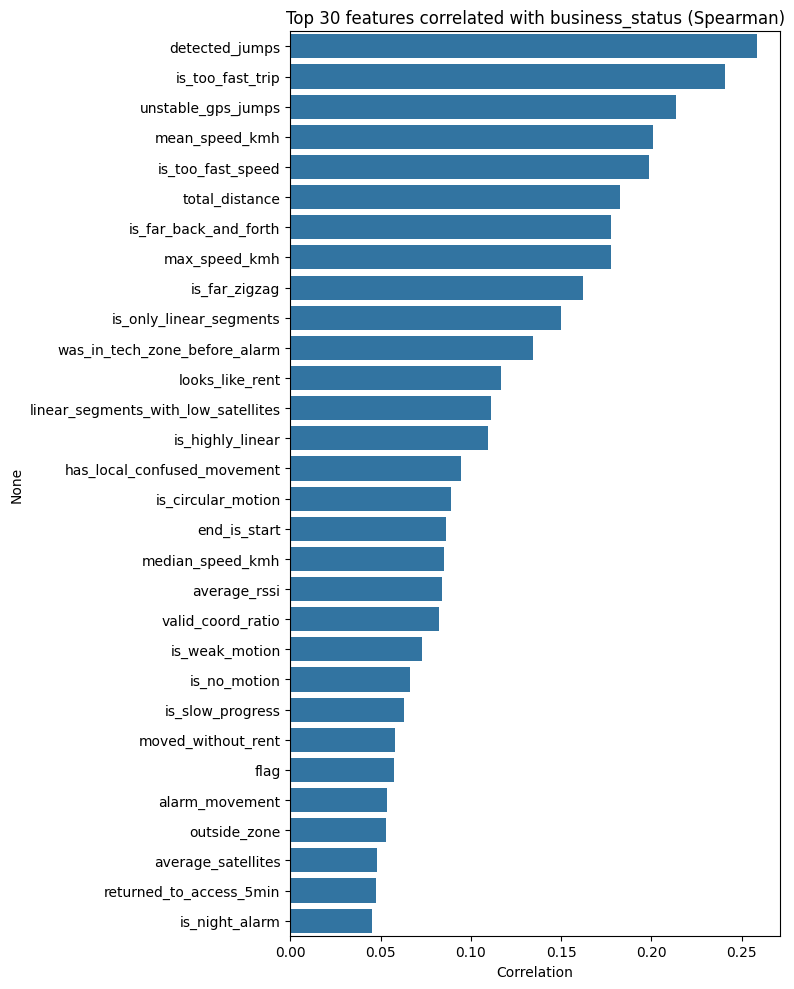

In [97]:
target = 'business_status'
num_cols = df.select_dtypes(include='number').columns.drop(['business_status', 'incident_id', 'Unnamed: 0'])

# Spearman корреляция с таргетом (устойчива к шкале и выбросам)
corr_with_target = df[num_cols].corrwith(df[target], method='spearman')

top_corr = corr_with_target.abs().sort_values(ascending=False).head(30)

plt.figure(figsize=(8, 10))
sns.barplot(x=top_corr.values, y=top_corr.index)
plt.title('Top 30 features correlated with business_status (Spearman)')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()

In [98]:
corr_matrix = df[num_cols].corr(method='spearman')

upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

threshold = 0.6
strong_corrs = (
    upper_triangle.stack()
    .reset_index()
    .rename(columns={'level_0': 'feature_1', 'level_1': 'feature_2', 0: 'spearman_corr'})
    .loc[lambda df: df['spearman_corr'].abs() > threshold]
    .sort_values(by='spearman_corr', key=lambda s: s.abs(), ascending=False)
)

pd.set_option('display.max_rows', None)
display(strong_corrs)


,feature_1,feature_2,spearman_corr
0,max_speed_kmh,mean_speed_kmh,0.951883
54,mean_speed_kmh,total_distance,0.927903
798,moved_immediately_after_rent,had_rent_last_2h,0.912441
660,is_slow_progress,moved_without_rent,-0.906051
9,max_speed_kmh,total_distance,0.892733
628,is_weak_motion,is_no_motion,0.879099
626,is_weak_motion,is_slow_progress,0.869809
630,is_weak_motion,moved_without_rent,-0.851004
986,valid_coord_ratio,average_satellites,0.849322
48,mean_speed_kmh,is_too_fast_trip,0.847072


### time-dependent Train-Valid-Test split, feature importance & selection

In [214]:
df["incident_created_at"] = pd.to_datetime(df["incident_created_at"])

train_df = df[df["incident_created_at"] < "2025-04-25"]
valid_df = df[(df["incident_created_at"] >= "2025-04-25") & (df["incident_created_at"] <  "2025-04-28")]
test_df  = df[(df["incident_created_at"] >= "2025-04-28") & (df["incident_created_at"] <= "2025-05-01")]

print(f"Train set: {train_df.shape[0]} строк")
print(f"Validation set: {valid_df.shape[0]} строк")
print(f"Test set: {test_df.shape[0]} строк")

Train set: 296857 строк
Validation set: 54470 строк
Test set: 52181 строк


In [216]:
features = [col for col in df.columns if col not in ["business_status", "incident_created_at", "alarm_id", "identifier", "incident_id", "Unnamed: 0"]]

X_train = train_df[features]
y_train = train_df["business_status"]

X_valid = valid_df[features]
y_valid = valid_df["business_status"]

X_test = test_df[features]
y_test = test_df["business_status"]

In [116]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

xgb_importance = pd.Series(xgb_model.feature_importances_, index=X_train.columns, name="xgb_importance")
rf_importance = pd.Series(rf_model.feature_importances_, index=X_train.columns, name="rf_importance")

feat_imp = pd.concat([xgb_importance, rf_importance], axis=1)
feat_imp["xgb_rank"] = feat_imp["xgb_importance"].rank(ascending=False)
feat_imp["rf_rank"] = feat_imp["rf_importance"].rank(ascending=False)
feat_imp["mean_rank"] = feat_imp[["xgb_rank", "rf_rank"]].mean(axis=1)

feat_imp = feat_imp.sort_values("mean_rank")
display(feat_imp.head(30))


/home/kdankova/jet_alerts/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:28:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,xgb_importance,rf_importance,xgb_rank,rf_rank,mean_rank
total_distance,0.085652,0.109200,2.0,1.0,1.5
mean_speed_kmh,0.020906,0.091132,3.0,2.0,2.5
average_satellites,0.014076,0.070330,6.0,5.0,5.5
end_is_start,0.559361,0.018756,1.0,13.0,7.0
max_speed_kmh,0.012098,0.090713,11.0,3.0,7.0
alarm_delay_seconds,0.009632,0.081952,16.0,4.0,10.0
median_speed_kmh,0.009884,0.061044,15.0,6.0,10.5
detected_jumps,0.011104,0.055800,14.0,8.0,11.0
had_rent_last_2h,0.018777,0.008037,4.0,21.0,12.5
is_slow_progress,0.012333,0.009897,9.0,17.0,13.0


100%|===================| 17463/17475 [01:17<00:00]        

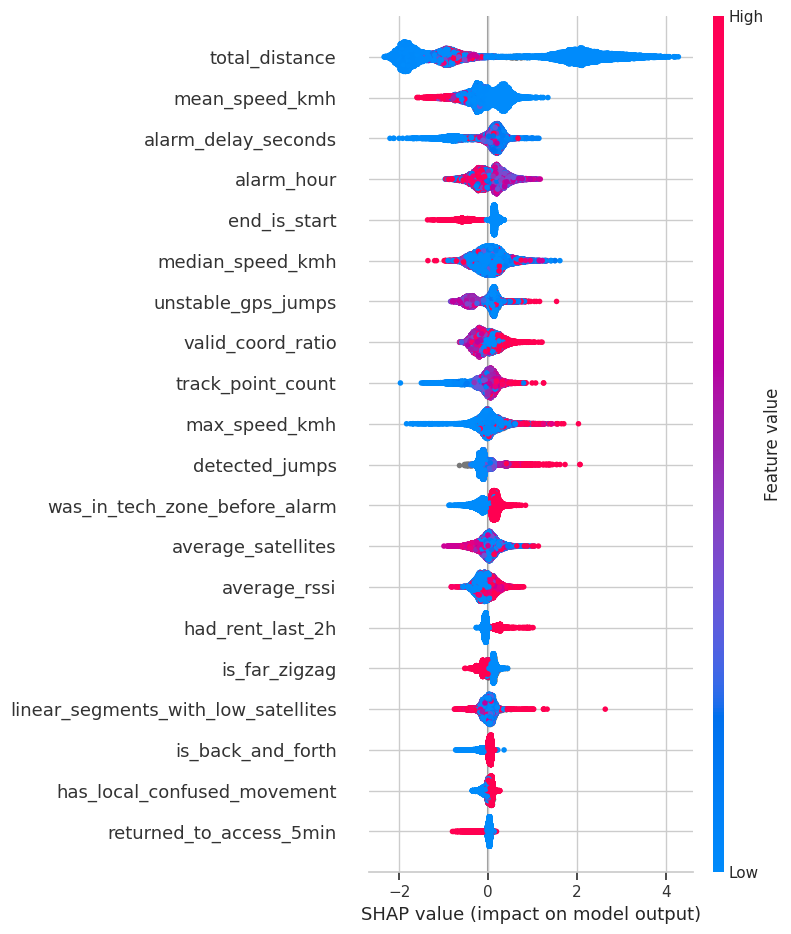

In [117]:
explainer = shap.Explainer(xgb_model, X_train, feature_names=X_train.columns)
shap_values = explainer(X_valid)

# Summary-график
# shap.plots.bar(shap_values, max_display=30)
# или
shap.summary_plot(shap_values.values, X_valid, feature_names=X_valid.columns)


In [121]:
imputer = SimpleImputer(strategy='median')

# L1-модель
l1_model = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=42)

# Pipeline с импутером и масштабированием
pipe = make_pipeline(imputer, StandardScaler(), l1_model)
pipe.fit(X_train, y_train)


model = pipe.named_steps['logisticregression']
coefs = model.coef_[0]

selected_features = [feature for coef, feature in zip(coefs, X_train.columns) if coef != 0]

print(f"Выбрано {len(selected_features)} признаков из {X_train.shape[1]}")
print(selected_features)

Выбрано 46 признаков из 48
['max_speed_kmh', 'mean_speed_kmh', 'median_speed_kmh', 'is_too_fast_speed', 'is_too_fast_trip', 'is_only_linear_segments', 'is_zigzag', 'is_back_and_forth', 'is_highly_linear', 'has_long_stop', 'total_distance', 'track_point_count', 'linear_segments_with_low_satellites', 'has_local_confused_movement', 'is_far_zigzag', 'is_far_back_and_forth', 'is_weak_motion', 'is_slow_progress', 'is_circular_motion', 'is_no_motion', 'looks_like_rent', 'moved_immediately_after_rent', 'returned_to_access_5min', 'had_rent_last_2h', 'end_is_start', 'is_night_alarm', 'alarm_hour', 'was_in_tech_zone_before_alarm', 'was_in_restricted_zone_before_alarm', 'valid_coord_ratio', 'average_satellites', 'average_rssi', 'unstable_gps_jumps', 'detected_jumps', 'flag', 'low_battery', 'needs_repair', 'gps_error', 'outside_zone', 'alarm_movement', 'returned_to_access', 'rent_blocked', 'awaiting_service', 'no_connection', 'alarm_delay_seconds_missing', 'mean_speed_kmh_missing']


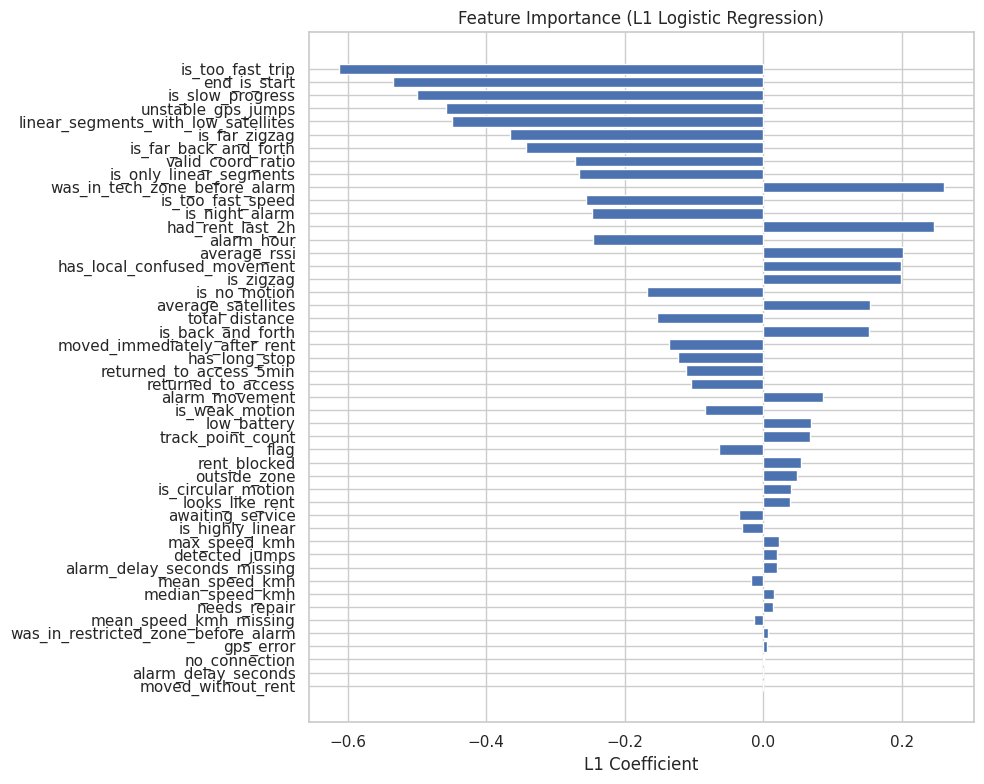

In [122]:
coefs = pipe.named_steps['logisticregression'].coef_[0]
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': coefs
}).sort_values(by='coefficient', key=lambda s: s.abs(), ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(coef_df['feature'], coef_df['coefficient'])
plt.xlabel("L1 Coefficient")
plt.title("Feature Importance (L1 Logistic Regression)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Model train

In [222]:
def find_threshold_for_recall(y_true, y_probs, target_recall=0.9, min_precision=0.2):
    best_t = None
    for t in np.arange(0.01, 1.0, 0.01):
        y_pred = (y_probs > t).astype(int)
        r = recall_score(y_true, y_pred)
        p = precision_score(y_true, y_pred, zero_division=0)
        if r >= target_recall and p >= min_precision:
            return t
    return 0.5

def find_threshold_for_fbeta(y_true, y_probs, beta=5.0, min_recall=0.0, min_precision=0.0):
    best_t = None
    best_score = -1
    for t in np.arange(0.01, 1.0, 0.01):
        y_pred = (y_probs > t).astype(int)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        if recall >= min_recall and precision >= min_precision:
            score = fbeta_score(y_true, y_pred, beta=beta, pos_label=1, average="binary")
            if score > best_score:
                best_score = score
                best_t = t
    return best_t if best_t is not None else 0.5 
    
def get_objective(metric):
    def objective(trial):
        try:
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 300, 3000, step=100),
                "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
                "subsample": trial.suggest_float("subsample", 0.5, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
                "gamma": trial.suggest_float("gamma", 0, 5),
                "reg_alpha": trial.suggest_float("reg_alpha", 1, 10),
                "reg_lambda": trial.suggest_float("reg_lambda", 1, 10),
                "max_depth": trial.suggest_int("max_depth", 3, 8),
                "min_child_weight": trial.suggest_int("min_child_weight", 1, 8),
                "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 20),
                "objective": "binary:logistic",
                "eval_metric": "logloss",
                "tree_method": "hist",
                "n_jobs": -1,
            }

            imputer = SimpleImputer(strategy="mean")
            X_train_imp = imputer.fit_transform(X_train)
            X_valid_imp = imputer.transform(X_valid)

            model = XGBClassifier(**params)
            model.fit(X_train_imp, y_train, eval_set=[(X_valid_imp, y_valid)], verbose=False)

            y_prob = model.predict_proba(X_valid_imp)[:, 1]

            best_score = -1
            for t in np.arange(0.01, 1.0, 0.01):
                y_pred = (y_prob > t).astype(int)

                if metric == "roc_auc":
                    score = roc_auc_score(y_valid, y_prob)  # threshold-independent
                    best_score = score
                    break  # нет смысла перебирать пороги

                elif metric == "f1":
                    score = f1_score(y_valid, y_pred)
                elif metric == "recall":
                    score = recall_score(y_valid, y_pred, pos_label=1, average='binary')
                elif metric == "fbeta":
                    score = fbeta_score(y_valid, y_pred, beta=5.0)

                if score > best_score:
                    best_score = score

        except Exception as e:
            print(f"[Trial {trial.number}] Ошибка: {e}")
            best_score = None

        del model, X_train_imp, X_valid_imp, y_prob, y_pred
        gc.collect()
        return best_score

    return objective


# === Коллбэк ===
def log_callback(study, trial):
    val = trial.value
    if val is None:
        print(f"[Trial {trial.number}] Failed. Params: {trial.params}")
    else:
        print(f"[Trial {trial.number}] Done. Value: {val:.5f} | Params: {trial.params}")


[I 2025-05-02 09:14:55,046] A new study created in memory with name: no-name-17aca513-1dd5-4bb7-9c0e-650f762d2978



 Оптимизация по метрике: recall


[I 2025-05-02 09:15:10,933] Trial 0 finished with value: 0.92680262199563 and parameters: {'n_estimators': 1100, 'max_depth': 3, 'learning_rate': 0.004853342439208682, 'subsample': 0.8469103113401095, 'colsample_bytree': 0.585571253381477, 'gamma': 4.178092948157731, 'reg_alpha': 3.0275449059428947, 'reg_lambda': 1.4851506003076094, 'min_child_weight': 4, 'scale_pos_weight': 13}. Best is trial 0 with value: 0.92680262199563.


[Trial 0] Done. Value: 0.92680 | Params: {'n_estimators': 1100, 'max_depth': 3, 'learning_rate': 0.004853342439208682, 'subsample': 0.8469103113401095, 'colsample_bytree': 0.585571253381477, 'gamma': 4.178092948157731, 'reg_alpha': 3.0275449059428947, 'reg_lambda': 1.4851506003076094, 'min_child_weight': 4, 'scale_pos_weight': 13}


[I 2025-05-02 09:15:38,882] Trial 1 finished with value: 0.45994173343044426 and parameters: {'n_estimators': 1500, 'max_depth': 6, 'learning_rate': 0.04673714132999589, 'subsample': 0.7199153981626022, 'colsample_bytree': 0.6975609283026987, 'gamma': 1.5950253956758442, 'reg_alpha': 4.81545591700166, 'reg_lambda': 3.761018854619509, 'min_child_weight': 5, 'scale_pos_weight': 2}. Best is trial 0 with value: 0.92680262199563.


[Trial 1] Done. Value: 0.45994 | Params: {'n_estimators': 1500, 'max_depth': 6, 'learning_rate': 0.04673714132999589, 'subsample': 0.7199153981626022, 'colsample_bytree': 0.6975609283026987, 'gamma': 1.5950253956758442, 'reg_alpha': 4.81545591700166, 'reg_lambda': 3.761018854619509, 'min_child_weight': 5, 'scale_pos_weight': 2}


[I 2025-05-02 09:16:03,867] Trial 2 finished with value: 0.8659868900218499 and parameters: {'n_estimators': 1400, 'max_depth': 5, 'learning_rate': 0.0043587772009484995, 'subsample': 0.9044250145327993, 'colsample_bytree': 0.533792555527727, 'gamma': 0.01536724195525696, 'reg_alpha': 1.1980514938517088, 'reg_lambda': 4.47781746572471, 'min_child_weight': 4, 'scale_pos_weight': 9}. Best is trial 0 with value: 0.92680262199563.


[Trial 2] Done. Value: 0.86599 | Params: {'n_estimators': 1400, 'max_depth': 5, 'learning_rate': 0.0043587772009484995, 'subsample': 0.9044250145327993, 'colsample_bytree': 0.533792555527727, 'gamma': 0.01536724195525696, 'reg_alpha': 1.1980514938517088, 'reg_lambda': 4.47781746572471, 'min_child_weight': 4, 'scale_pos_weight': 9}


[I 2025-05-02 09:16:18,578] Trial 3 finished with value: 0.049526584122359794 and parameters: {'n_estimators': 800, 'max_depth': 5, 'learning_rate': 0.002990352657352208, 'subsample': 0.7002985295401415, 'colsample_bytree': 0.949972615796748, 'gamma': 0.053659179963712056, 'reg_alpha': 0.03977525498009893, 'reg_lambda': 4.6769852733270065, 'min_child_weight': 5, 'scale_pos_weight': 1}. Best is trial 0 with value: 0.92680262199563.


[Trial 3] Done. Value: 0.04953 | Params: {'n_estimators': 800, 'max_depth': 5, 'learning_rate': 0.002990352657352208, 'subsample': 0.7002985295401415, 'colsample_bytree': 0.949972615796748, 'gamma': 0.053659179963712056, 'reg_alpha': 0.03977525498009893, 'reg_lambda': 4.6769852733270065, 'min_child_weight': 5, 'scale_pos_weight': 1}


[I 2025-05-02 09:17:25,867] Trial 4 finished with value: 0.31937363437727606 and parameters: {'n_estimators': 2900, 'max_depth': 7, 'learning_rate': 0.03109120680952062, 'subsample': 0.6174721968873235, 'colsample_bytree': 0.8523091383323362, 'gamma': 0.3410711044118636, 'reg_alpha': 4.969715732327601, 'reg_lambda': 2.863382558795018, 'min_child_weight': 3, 'scale_pos_weight': 1}. Best is trial 0 with value: 0.92680262199563.


[Trial 4] Done. Value: 0.31937 | Params: {'n_estimators': 2900, 'max_depth': 7, 'learning_rate': 0.03109120680952062, 'subsample': 0.6174721968873235, 'colsample_bytree': 0.8523091383323362, 'gamma': 0.3410711044118636, 'reg_alpha': 4.969715732327601, 'reg_lambda': 2.863382558795018, 'min_child_weight': 3, 'scale_pos_weight': 1}


[I 2025-05-02 09:17:47,479] Trial 5 finished with value: 0.8809176984705025 and parameters: {'n_estimators': 1300, 'max_depth': 4, 'learning_rate': 0.001708110078107205, 'subsample': 0.6791950304614642, 'colsample_bytree': 0.5135282548347166, 'gamma': 4.313745120316928, 'reg_alpha': 0.017517012798758946, 'reg_lambda': 3.5303252069718685, 'min_child_weight': 4, 'scale_pos_weight': 9}. Best is trial 0 with value: 0.92680262199563.


[Trial 5] Done. Value: 0.88092 | Params: {'n_estimators': 1300, 'max_depth': 4, 'learning_rate': 0.001708110078107205, 'subsample': 0.6791950304614642, 'colsample_bytree': 0.5135282548347166, 'gamma': 4.313745120316928, 'reg_alpha': 0.017517012798758946, 'reg_lambda': 3.5303252069718685, 'min_child_weight': 4, 'scale_pos_weight': 9}


[I 2025-05-02 09:17:56,067] Trial 6 finished with value: 0.5418790968681719 and parameters: {'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.25930464061976677, 'subsample': 0.6492498829408678, 'colsample_bytree': 0.5781511006153849, 'gamma': 2.7600178874393695, 'reg_alpha': 3.5858336719919577, 'reg_lambda': 2.8600522427736452, 'min_child_weight': 5, 'scale_pos_weight': 3}. Best is trial 0 with value: 0.92680262199563.


[Trial 6] Done. Value: 0.54188 | Params: {'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.25930464061976677, 'subsample': 0.6492498829408678, 'colsample_bytree': 0.5781511006153849, 'gamma': 2.7600178874393695, 'reg_alpha': 3.5858336719919577, 'reg_lambda': 2.8600522427736452, 'min_child_weight': 5, 'scale_pos_weight': 3}


[I 2025-05-02 09:18:34,940] Trial 7 finished with value: 0.3328477785870357 and parameters: {'n_estimators': 1500, 'max_depth': 9, 'learning_rate': 0.09622497689158123, 'subsample': 0.7138792934896665, 'colsample_bytree': 0.9379468268324278, 'gamma': 0.42961169840275815, 'reg_alpha': 0.08989591721838552, 'reg_lambda': 1.6158854353991337, 'min_child_weight': 7, 'scale_pos_weight': 1}. Best is trial 0 with value: 0.92680262199563.


[Trial 7] Done. Value: 0.33285 | Params: {'n_estimators': 1500, 'max_depth': 9, 'learning_rate': 0.09622497689158123, 'subsample': 0.7138792934896665, 'colsample_bytree': 0.9379468268324278, 'gamma': 0.42961169840275815, 'reg_alpha': 0.08989591721838552, 'reg_lambda': 1.6158854353991337, 'min_child_weight': 7, 'scale_pos_weight': 1}


[I 2025-05-02 09:18:47,990] Trial 8 finished with value: 0.702476329206118 and parameters: {'n_estimators': 700, 'max_depth': 5, 'learning_rate': 0.0017683535351704803, 'subsample': 0.7386090779160048, 'colsample_bytree': 0.5097170254234897, 'gamma': 2.6939993770637773, 'reg_alpha': 1.053421039021896, 'reg_lambda': 4.514429579413968, 'min_child_weight': 5, 'scale_pos_weight': 8}. Best is trial 0 with value: 0.92680262199563.


[Trial 8] Done. Value: 0.70248 | Params: {'n_estimators': 700, 'max_depth': 5, 'learning_rate': 0.0017683535351704803, 'subsample': 0.7386090779160048, 'colsample_bytree': 0.5097170254234897, 'gamma': 2.6939993770637773, 'reg_alpha': 1.053421039021896, 'reg_lambda': 4.514429579413968, 'min_child_weight': 5, 'scale_pos_weight': 8}


[I 2025-05-02 09:19:42,119] Trial 9 finished with value: 0.831755280407866 and parameters: {'n_estimators': 1500, 'max_depth': 12, 'learning_rate': 0.004042349068844926, 'subsample': 0.8675213736043739, 'colsample_bytree': 0.6526922563742574, 'gamma': 3.3973782632293426, 'reg_alpha': 4.839709622269439, 'reg_lambda': 4.618337301153255, 'min_child_weight': 1, 'scale_pos_weight': 13}. Best is trial 0 with value: 0.92680262199563.


[Trial 9] Done. Value: 0.83176 | Params: {'n_estimators': 1500, 'max_depth': 12, 'learning_rate': 0.004042349068844926, 'subsample': 0.8675213736043739, 'colsample_bytree': 0.6526922563742574, 'gamma': 3.3973782632293426, 'reg_alpha': 4.839709622269439, 'reg_lambda': 4.618337301153255, 'min_child_weight': 1, 'scale_pos_weight': 13}

[recall] ── Финальные метрики на TEST ──
Порог: 0.76
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     47064
           1       0.40      0.59      0.48      2936

    accuracy                           0.92     50000
   macro avg       0.69      0.77      0.72     50000
weighted avg       0.94      0.92      0.93     50000

ROC AUC: 0.9325968883290003


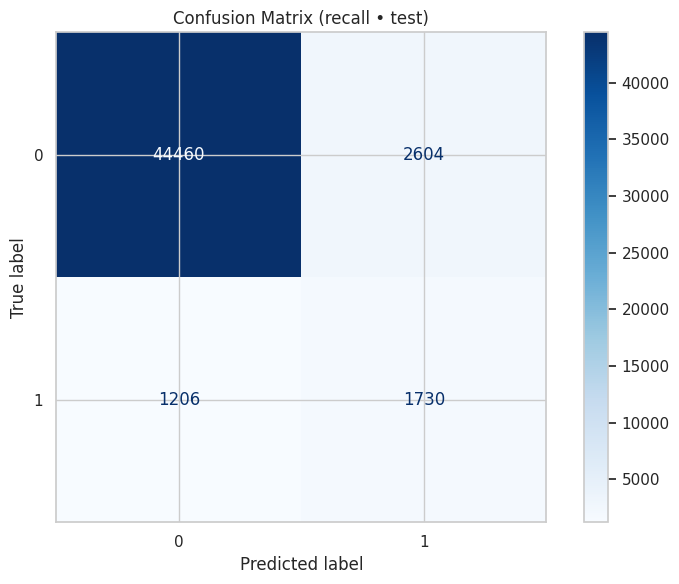

[I 2025-05-02 09:19:55,931] A new study created in memory with name: no-name-4cc32ffa-da45-4333-b2c9-a33847415049



 Оптимизация по метрике: roc_auc


[I 2025-05-02 09:20:34,144] Trial 0 finished with value: 0.9363897824994434 and parameters: {'n_estimators': 2200, 'max_depth': 10, 'learning_rate': 0.18010965137474405, 'subsample': 0.5631055584946344, 'colsample_bytree': 0.5427816111629095, 'gamma': 2.006364572386663, 'reg_alpha': 4.847536809715404, 'reg_lambda': 0.04827514624519358, 'min_child_weight': 8, 'scale_pos_weight': 4}. Best is trial 0 with value: 0.9363897824994434.


[Trial 0] Done. Value: 0.93639 | Params: {'n_estimators': 2200, 'max_depth': 10, 'learning_rate': 0.18010965137474405, 'subsample': 0.5631055584946344, 'colsample_bytree': 0.5427816111629095, 'gamma': 2.006364572386663, 'reg_alpha': 4.847536809715404, 'reg_lambda': 0.04827514624519358, 'min_child_weight': 8, 'scale_pos_weight': 4}


[I 2025-05-02 09:21:00,720] Trial 1 finished with value: 0.9435346167067065 and parameters: {'n_estimators': 700, 'max_depth': 15, 'learning_rate': 0.0016126175401796413, 'subsample': 0.8877315230471317, 'colsample_bytree': 0.5641107493448883, 'gamma': 2.161999841137565, 'reg_alpha': 4.32698976029811, 'reg_lambda': 3.5646365073545425, 'min_child_weight': 4, 'scale_pos_weight': 5}. Best is trial 1 with value: 0.9435346167067065.


[Trial 1] Done. Value: 0.94353 | Params: {'n_estimators': 700, 'max_depth': 15, 'learning_rate': 0.0016126175401796413, 'subsample': 0.8877315230471317, 'colsample_bytree': 0.5641107493448883, 'gamma': 2.161999841137565, 'reg_alpha': 4.32698976029811, 'reg_lambda': 3.5646365073545425, 'min_child_weight': 4, 'scale_pos_weight': 5}


[I 2025-05-02 09:21:31,728] Trial 2 finished with value: 0.9424788942594747 and parameters: {'n_estimators': 2600, 'max_depth': 3, 'learning_rate': 0.015599855808197238, 'subsample': 0.8865367760954715, 'colsample_bytree': 0.5983005206211832, 'gamma': 4.581103198957198, 'reg_alpha': 1.0483589145868093, 'reg_lambda': 0.665205864053659, 'min_child_weight': 1, 'scale_pos_weight': 11}. Best is trial 1 with value: 0.9435346167067065.


[Trial 2] Done. Value: 0.94248 | Params: {'n_estimators': 2600, 'max_depth': 3, 'learning_rate': 0.015599855808197238, 'subsample': 0.8865367760954715, 'colsample_bytree': 0.5983005206211832, 'gamma': 4.581103198957198, 'reg_alpha': 1.0483589145868093, 'reg_lambda': 0.665205864053659, 'min_child_weight': 1, 'scale_pos_weight': 11}


[I 2025-05-02 09:21:54,031] Trial 3 finished with value: 0.9398315887261082 and parameters: {'n_estimators': 1100, 'max_depth': 11, 'learning_rate': 0.08372006647078757, 'subsample': 0.5846770158070538, 'colsample_bytree': 0.9705274379886731, 'gamma': 3.5492722696839207, 'reg_alpha': 1.7686696656853473, 'reg_lambda': 4.315111494358125, 'min_child_weight': 1, 'scale_pos_weight': 7}. Best is trial 1 with value: 0.9435346167067065.


[Trial 3] Done. Value: 0.93983 | Params: {'n_estimators': 1100, 'max_depth': 11, 'learning_rate': 0.08372006647078757, 'subsample': 0.5846770158070538, 'colsample_bytree': 0.9705274379886731, 'gamma': 3.5492722696839207, 'reg_alpha': 1.7686696656853473, 'reg_lambda': 4.315111494358125, 'min_child_weight': 1, 'scale_pos_weight': 7}


[I 2025-05-02 09:22:15,029] Trial 4 finished with value: 0.943866376657293 and parameters: {'n_estimators': 1500, 'max_depth': 16, 'learning_rate': 0.05182328019649538, 'subsample': 0.7045809201485362, 'colsample_bytree': 0.9584299770735398, 'gamma': 4.806166864106711, 'reg_alpha': 3.168345733719822, 'reg_lambda': 0.920622361361334, 'min_child_weight': 3, 'scale_pos_weight': 7}. Best is trial 4 with value: 0.943866376657293.


[Trial 4] Done. Value: 0.94387 | Params: {'n_estimators': 1500, 'max_depth': 16, 'learning_rate': 0.05182328019649538, 'subsample': 0.7045809201485362, 'colsample_bytree': 0.9584299770735398, 'gamma': 4.806166864106711, 'reg_alpha': 3.168345733719822, 'reg_lambda': 0.920622361361334, 'min_child_weight': 3, 'scale_pos_weight': 7}


[I 2025-05-02 09:22:25,376] Trial 5 finished with value: 0.9423131298826682 and parameters: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.1388196956288634, 'subsample': 0.838564920944201, 'colsample_bytree': 0.9458534021752428, 'gamma': 0.6382259378810273, 'reg_alpha': 0.7889348828453591, 'reg_lambda': 4.241087048263719, 'min_child_weight': 4, 'scale_pos_weight': 16}. Best is trial 4 with value: 0.943866376657293.


[Trial 5] Done. Value: 0.94231 | Params: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.1388196956288634, 'subsample': 0.838564920944201, 'colsample_bytree': 0.9458534021752428, 'gamma': 0.6382259378810273, 'reg_alpha': 0.7889348828453591, 'reg_lambda': 4.241087048263719, 'min_child_weight': 4, 'scale_pos_weight': 16}


[I 2025-05-02 09:23:31,092] Trial 6 finished with value: 0.9466076676137214 and parameters: {'n_estimators': 2100, 'max_depth': 16, 'learning_rate': 0.0036371648157802077, 'subsample': 0.8605334060595592, 'colsample_bytree': 0.5619056913917575, 'gamma': 0.0821049243060662, 'reg_alpha': 2.6635137664737996, 'reg_lambda': 1.8506783092017953, 'min_child_weight': 7, 'scale_pos_weight': 1}. Best is trial 6 with value: 0.9466076676137214.


[Trial 6] Done. Value: 0.94661 | Params: {'n_estimators': 2100, 'max_depth': 16, 'learning_rate': 0.0036371648157802077, 'subsample': 0.8605334060595592, 'colsample_bytree': 0.5619056913917575, 'gamma': 0.0821049243060662, 'reg_alpha': 2.6635137664737996, 'reg_lambda': 1.8506783092017953, 'min_child_weight': 7, 'scale_pos_weight': 1}


[I 2025-05-02 09:24:01,887] Trial 7 finished with value: 0.9404360378005202 and parameters: {'n_estimators': 3000, 'max_depth': 11, 'learning_rate': 0.09712293562376983, 'subsample': 0.9035714643809292, 'colsample_bytree': 0.9776460533902064, 'gamma': 2.668583187186244, 'reg_alpha': 4.742594133782532, 'reg_lambda': 1.2263740574861766, 'min_child_weight': 4, 'scale_pos_weight': 20}. Best is trial 6 with value: 0.9466076676137214.


[Trial 7] Done. Value: 0.94044 | Params: {'n_estimators': 3000, 'max_depth': 11, 'learning_rate': 0.09712293562376983, 'subsample': 0.9035714643809292, 'colsample_bytree': 0.9776460533902064, 'gamma': 2.668583187186244, 'reg_alpha': 4.742594133782532, 'reg_lambda': 1.2263740574861766, 'min_child_weight': 4, 'scale_pos_weight': 20}


[I 2025-05-02 09:24:26,314] Trial 8 finished with value: 0.9387327827228413 and parameters: {'n_estimators': 2200, 'max_depth': 6, 'learning_rate': 0.192209933988137, 'subsample': 0.8142639631696389, 'colsample_bytree': 0.7708662998191675, 'gamma': 4.577510878445724, 'reg_alpha': 1.00526594533763, 'reg_lambda': 4.7632880860007205, 'min_child_weight': 7, 'scale_pos_weight': 9}. Best is trial 6 with value: 0.9466076676137214.


[Trial 8] Done. Value: 0.93873 | Params: {'n_estimators': 2200, 'max_depth': 6, 'learning_rate': 0.192209933988137, 'subsample': 0.8142639631696389, 'colsample_bytree': 0.7708662998191675, 'gamma': 4.577510878445724, 'reg_alpha': 1.00526594533763, 'reg_lambda': 4.7632880860007205, 'min_child_weight': 7, 'scale_pos_weight': 9}


[I 2025-05-02 09:24:41,007] Trial 9 finished with value: 0.9422063322939848 and parameters: {'n_estimators': 1100, 'max_depth': 3, 'learning_rate': 0.03739501457613865, 'subsample': 0.6525388050369628, 'colsample_bytree': 0.5816291947299168, 'gamma': 1.876163828731553, 'reg_alpha': 4.074362138429065, 'reg_lambda': 4.4684063697148275, 'min_child_weight': 5, 'scale_pos_weight': 10}. Best is trial 6 with value: 0.9466076676137214.


[Trial 9] Done. Value: 0.94221 | Params: {'n_estimators': 1100, 'max_depth': 3, 'learning_rate': 0.03739501457613865, 'subsample': 0.6525388050369628, 'colsample_bytree': 0.5816291947299168, 'gamma': 1.876163828731553, 'reg_alpha': 4.074362138429065, 'reg_lambda': 4.4684063697148275, 'min_child_weight': 5, 'scale_pos_weight': 10}

[roc_auc] ── Финальные метрики на TEST ──
Порог: 0.24
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     47064
           1       0.50      0.60      0.54      2936

    accuracy                           0.94     50000
   macro avg       0.74      0.78      0.76     50000
weighted avg       0.95      0.94      0.94     50000

ROC AUC: 0.948467293044291


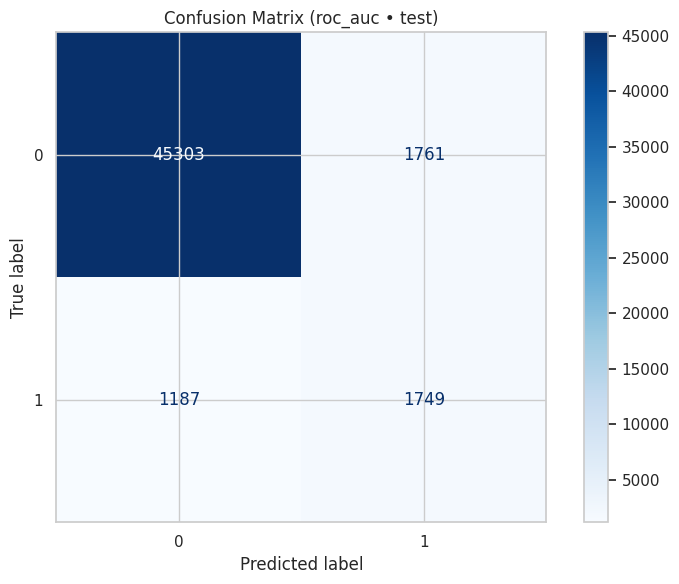

[I 2025-05-02 09:25:44,379] A new study created in memory with name: no-name-a05b3ba6-26c3-4b94-83cc-ce147d6ff477



 Оптимизация по метрике: f1


[I 2025-05-02 09:26:47,994] Trial 0 finished with value: 0.5083805619196913 and parameters: {'n_estimators': 1700, 'max_depth': 14, 'learning_rate': 0.0038459108282690117, 'subsample': 0.7261964870995226, 'colsample_bytree': 0.6404627883233294, 'gamma': 3.6233599854461347, 'reg_alpha': 2.3925051842099516, 'reg_lambda': 4.030977350439949, 'min_child_weight': 3, 'scale_pos_weight': 10}. Best is trial 0 with value: 0.5083805619196913.


[Trial 0] Done. Value: 0.50838 | Params: {'n_estimators': 1700, 'max_depth': 14, 'learning_rate': 0.0038459108282690117, 'subsample': 0.7261964870995226, 'colsample_bytree': 0.6404627883233294, 'gamma': 3.6233599854461347, 'reg_alpha': 2.3925051842099516, 'reg_lambda': 4.030977350439949, 'min_child_weight': 3, 'scale_pos_weight': 10}


[I 2025-05-02 09:26:58,911] Trial 1 finished with value: 0.5293608175991685 and parameters: {'n_estimators': 600, 'max_depth': 15, 'learning_rate': 0.05855204001021835, 'subsample': 0.6475982640084035, 'colsample_bytree': 0.9456512284603233, 'gamma': 4.854859494514412, 'reg_alpha': 2.5540357046168065, 'reg_lambda': 4.087296775676086, 'min_child_weight': 7, 'scale_pos_weight': 3}. Best is trial 1 with value: 0.5293608175991685.


[Trial 1] Done. Value: 0.52936 | Params: {'n_estimators': 600, 'max_depth': 15, 'learning_rate': 0.05855204001021835, 'subsample': 0.6475982640084035, 'colsample_bytree': 0.9456512284603233, 'gamma': 4.854859494514412, 'reg_alpha': 2.5540357046168065, 'reg_lambda': 4.087296775676086, 'min_child_weight': 7, 'scale_pos_weight': 3}


[I 2025-05-02 09:27:12,334] Trial 2 finished with value: 0.5119232763089684 and parameters: {'n_estimators': 800, 'max_depth': 5, 'learning_rate': 0.027157589607852008, 'subsample': 0.7138849097794382, 'colsample_bytree': 0.7457868976027029, 'gamma': 0.9245919432838057, 'reg_alpha': 2.2471693779295543, 'reg_lambda': 3.1568625662573218, 'min_child_weight': 8, 'scale_pos_weight': 5}. Best is trial 1 with value: 0.5293608175991685.


[Trial 2] Done. Value: 0.51192 | Params: {'n_estimators': 800, 'max_depth': 5, 'learning_rate': 0.027157589607852008, 'subsample': 0.7138849097794382, 'colsample_bytree': 0.7457868976027029, 'gamma': 0.9245919432838057, 'reg_alpha': 2.2471693779295543, 'reg_lambda': 3.1568625662573218, 'min_child_weight': 8, 'scale_pos_weight': 5}


[I 2025-05-02 09:27:46,241] Trial 3 finished with value: 0.497096692754355 and parameters: {'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.0012052942251289287, 'subsample': 0.5800047466391105, 'colsample_bytree': 0.8888805053273703, 'gamma': 0.5769274617254955, 'reg_alpha': 2.011054903681202, 'reg_lambda': 2.387920054278923, 'min_child_weight': 4, 'scale_pos_weight': 8}. Best is trial 1 with value: 0.5293608175991685.


[Trial 3] Done. Value: 0.49710 | Params: {'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.0012052942251289287, 'subsample': 0.5800047466391105, 'colsample_bytree': 0.8888805053273703, 'gamma': 0.5769274617254955, 'reg_alpha': 2.011054903681202, 'reg_lambda': 2.387920054278923, 'min_child_weight': 4, 'scale_pos_weight': 8}


[I 2025-05-02 09:28:40,574] Trial 4 finished with value: 0.5134328358208955 and parameters: {'n_estimators': 2200, 'max_depth': 15, 'learning_rate': 0.028783626668612044, 'subsample': 0.5205880018238516, 'colsample_bytree': 0.7761808427625414, 'gamma': 2.948399795874349, 'reg_alpha': 4.132039798456097, 'reg_lambda': 0.5744427129350149, 'min_child_weight': 4, 'scale_pos_weight': 10}. Best is trial 1 with value: 0.5293608175991685.


[Trial 4] Done. Value: 0.51343 | Params: {'n_estimators': 2200, 'max_depth': 15, 'learning_rate': 0.028783626668612044, 'subsample': 0.5205880018238516, 'colsample_bytree': 0.7761808427625414, 'gamma': 2.948399795874349, 'reg_alpha': 4.132039798456097, 'reg_lambda': 0.5744427129350149, 'min_child_weight': 4, 'scale_pos_weight': 10}


[I 2025-05-02 09:29:03,602] Trial 5 finished with value: 0.4143318050602819 and parameters: {'n_estimators': 1600, 'max_depth': 4, 'learning_rate': 0.06446749717626223, 'subsample': 0.5997939648687594, 'colsample_bytree': 0.8508327709209824, 'gamma': 3.760550198251354, 'reg_alpha': 2.621537332053328, 'reg_lambda': 3.811241387762351, 'min_child_weight': 7, 'scale_pos_weight': 15}. Best is trial 1 with value: 0.5293608175991685.


[Trial 5] Done. Value: 0.41433 | Params: {'n_estimators': 1600, 'max_depth': 4, 'learning_rate': 0.06446749717626223, 'subsample': 0.5997939648687594, 'colsample_bytree': 0.8508327709209824, 'gamma': 3.760550198251354, 'reg_alpha': 2.621537332053328, 'reg_lambda': 3.811241387762351, 'min_child_weight': 7, 'scale_pos_weight': 15}


[I 2025-05-02 09:29:37,042] Trial 6 finished with value: 0.5156682699314968 and parameters: {'n_estimators': 2900, 'max_depth': 11, 'learning_rate': 0.08341352612138374, 'subsample': 0.980169563100343, 'colsample_bytree': 0.8332801807065744, 'gamma': 0.8853533541941672, 'reg_alpha': 0.049152532516600345, 'reg_lambda': 2.7391598409578544, 'min_child_weight': 5, 'scale_pos_weight': 13}. Best is trial 1 with value: 0.5293608175991685.


[Trial 6] Done. Value: 0.51567 | Params: {'n_estimators': 2900, 'max_depth': 11, 'learning_rate': 0.08341352612138374, 'subsample': 0.980169563100343, 'colsample_bytree': 0.8332801807065744, 'gamma': 0.8853533541941672, 'reg_alpha': 0.049152532516600345, 'reg_lambda': 2.7391598409578544, 'min_child_weight': 5, 'scale_pos_weight': 13}


[I 2025-05-02 09:30:08,661] Trial 7 finished with value: 0.5273752012882448 and parameters: {'n_estimators': 1100, 'max_depth': 11, 'learning_rate': 0.010181408151144194, 'subsample': 0.7690193723663309, 'colsample_bytree': 0.5973762330737691, 'gamma': 3.610933689332466, 'reg_alpha': 3.365044280830056, 'reg_lambda': 3.1465626481192723, 'min_child_weight': 6, 'scale_pos_weight': 6}. Best is trial 1 with value: 0.5293608175991685.


[Trial 7] Done. Value: 0.52738 | Params: {'n_estimators': 1100, 'max_depth': 11, 'learning_rate': 0.010181408151144194, 'subsample': 0.7690193723663309, 'colsample_bytree': 0.5973762330737691, 'gamma': 3.610933689332466, 'reg_alpha': 3.365044280830056, 'reg_lambda': 3.1465626481192723, 'min_child_weight': 6, 'scale_pos_weight': 6}


[I 2025-05-02 09:30:58,191] Trial 8 finished with value: 0.4110913253625032 and parameters: {'n_estimators': 1400, 'max_depth': 11, 'learning_rate': 0.0022185734568033757, 'subsample': 0.9823691895493649, 'colsample_bytree': 0.6278314778615672, 'gamma': 1.6146747876528584, 'reg_alpha': 0.2893831845235295, 'reg_lambda': 3.5399174874343915, 'min_child_weight': 5, 'scale_pos_weight': 15}. Best is trial 1 with value: 0.5293608175991685.


[Trial 8] Done. Value: 0.41109 | Params: {'n_estimators': 1400, 'max_depth': 11, 'learning_rate': 0.0022185734568033757, 'subsample': 0.9823691895493649, 'colsample_bytree': 0.6278314778615672, 'gamma': 1.6146747876528584, 'reg_alpha': 0.2893831845235295, 'reg_lambda': 3.5399174874343915, 'min_child_weight': 5, 'scale_pos_weight': 15}


[I 2025-05-02 09:31:30,695] Trial 9 finished with value: 0.06780845858091576 and parameters: {'n_estimators': 2000, 'max_depth': 4, 'learning_rate': 0.0014834607073012085, 'subsample': 0.999870280710583, 'colsample_bytree': 0.7438258317452805, 'gamma': 4.246083422914623, 'reg_alpha': 0.2912090284121138, 'reg_lambda': 2.366986878572896, 'min_child_weight': 5, 'scale_pos_weight': 1}. Best is trial 1 with value: 0.5293608175991685.


[Trial 9] Done. Value: 0.06781 | Params: {'n_estimators': 2000, 'max_depth': 4, 'learning_rate': 0.0014834607073012085, 'subsample': 0.999870280710583, 'colsample_bytree': 0.7438258317452805, 'gamma': 4.246083422914623, 'reg_alpha': 0.2912090284121138, 'reg_lambda': 2.366986878572896, 'min_child_weight': 5, 'scale_pos_weight': 1}

[f1] ── Финальные метрики на TEST ──
Порог: 0.44
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     47064
           1       0.48      0.61      0.54      2936

    accuracy                           0.94     50000
   macro avg       0.73      0.79      0.75     50000
weighted avg       0.95      0.94      0.94     50000

ROC AUC: 0.9475119515208231


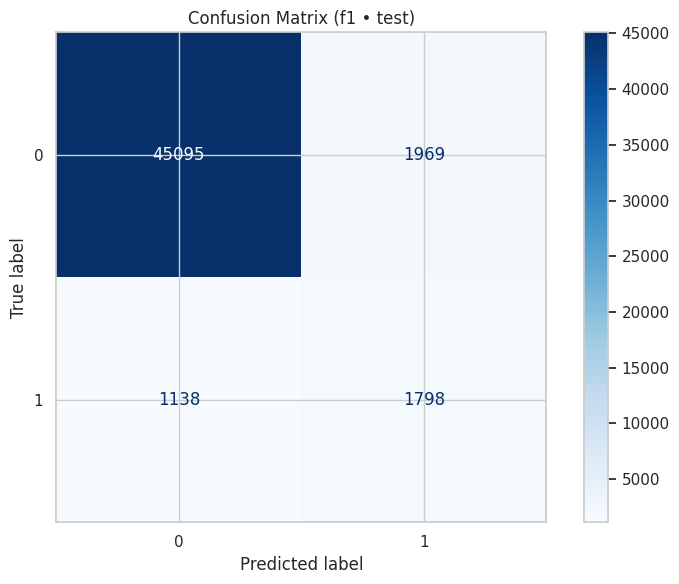

In [187]:
# === Основной цикл ===
optuna.logging.set_verbosity(optuna.logging.INFO)
metrics = ["recall", "roc_auc", "f1"]
best_models = {}

os.makedirs("../data", exist_ok=True)

for metric in metrics:
    print(f"\n Оптимизация по метрике: {metric}")
    study = optuna.create_study(direction="maximize")
    study.optimize(
        get_objective(metric),
        n_trials=10,
        timeout=3600,
        callbacks=[log_callback]
    )

    best_params = study.best_trial.params

    pipeline = make_pipeline(
        SimpleImputer(strategy="mean"),
        XGBClassifier(**best_params, objective="binary:logistic", eval_metric="logloss", n_jobs=-1)
    )
    pipeline.fit(X_train, y_train)

    val_probs = pipeline.predict_proba(X_valid)[:, 1]
    best_thr = find_best_threshold(y_valid, val_probs)

    test_probs = pipeline.predict_proba(X_test)[:, 1]
    test_pred = (test_probs > best_thr).astype(int)

    print(f"\n[{metric}] ── Финальные метрики на TEST ──")
    print(f"Порог: {best_thr:.2f}")
    print(classification_report(y_test, test_pred))
    print("ROC AUC:", roc_auc_score(y_test, test_probs))

    cm = confusion_matrix(y_test, test_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])\
        .plot(cmap="Blues", values_format='d')
    plt.title(f"Confusion Matrix ({metric} • test)")
    plt.tight_layout(); plt.show()

    with open(f"../data/final_model_{metric}.pkl", "wb") as f:
        pickle.dump({"model": pipeline, "threshold": best_thr}, f)

    best_models[metric] = pipeline


In [223]:
optuna.logging.set_verbosity(optuna.logging.INFO)
metrics = ["recall"]
best_models = {}

os.makedirs("../data", exist_ok=True)

for metric in metrics:
    print(f"\n Оптимизация по метрике: {metric}")
    study = optuna.create_study(direction="maximize")
    study.optimize(
        get_objective(metric),
        n_trials=10,
        timeout=3600,
        callbacks=[log_callback]
    )

    best_params = study.best_trial.params

    pipeline = make_pipeline(
        SimpleImputer(strategy="mean"),
        XGBClassifier(**best_params, objective="binary:logistic", eval_metric="logloss", n_jobs=-1)
    )
    pipeline.fit(X_train, y_train)

    val_probs = pipeline.predict_proba(X_valid)[:, 1]
    best_thr = find_threshold_for_recall(y_valid, val_probs)

    test_probs = pipeline.predict_proba(X_test)[:, 1]
    test_pred = (test_probs > best_thr).astype(int)

    print(f"\n[{metric}] ── Финальные метрики на TEST ──")
    print(f"Порог: {best_thr:.2f}")
    print(classification_report(y_test, test_pred))
    print("ROC AUC:", roc_auc_score(y_test, test_probs))

    cm = confusion_matrix(y_test, test_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])\
        .plot(cmap="Blues", values_format='d')
    plt.title(f"Confusion Matrix ({metric} • test)")
    plt.tight_layout(); plt.show()

    with open(f"../data/final_model_{metric}.pkl", "wb") as f:
        pickle.dump({"model": pipeline, "threshold": best_thr}, f)

    best_models[metric] = pipeline


[I 2025-05-02 12:45:45,158] A new study created in memory with name: no-name-85da566f-dd3c-4481-9ffa-e99ab28c71c6



 Оптимизация по метрике: recall


[I 2025-05-02 12:46:11,710] Trial 0 finished with value: 0.996268656716418 and parameters: {'n_estimators': 1400, 'learning_rate': 0.006543563873627695, 'subsample': 0.684177370777024, 'colsample_bytree': 0.7725670408802287, 'gamma': 0.7814089443571154, 'reg_alpha': 9.198904678517888, 'reg_lambda': 1.8148675424856406, 'max_depth': 5, 'min_child_weight': 5, 'scale_pos_weight': 10}. Best is trial 0 with value: 0.996268656716418.


[Trial 0] Done. Value: 0.99627 | Params: {'n_estimators': 1400, 'learning_rate': 0.006543563873627695, 'subsample': 0.684177370777024, 'colsample_bytree': 0.7725670408802287, 'gamma': 0.7814089443571154, 'reg_alpha': 9.198904678517888, 'reg_lambda': 1.8148675424856406, 'max_depth': 5, 'min_child_weight': 5, 'scale_pos_weight': 10}


[I 2025-05-02 12:46:33,941] Trial 1 finished with value: 0.980325644504749 and parameters: {'n_estimators': 1900, 'learning_rate': 0.05333075492108305, 'subsample': 0.5512608202121085, 'colsample_bytree': 0.8024752379396116, 'gamma': 4.581638002091194, 'reg_alpha': 6.584282628215732, 'reg_lambda': 1.4860389000505032, 'max_depth': 5, 'min_child_weight': 6, 'scale_pos_weight': 1}. Best is trial 0 with value: 0.996268656716418.


[Trial 1] Done. Value: 0.98033 | Params: {'n_estimators': 1900, 'learning_rate': 0.05333075492108305, 'subsample': 0.5512608202121085, 'colsample_bytree': 0.8024752379396116, 'gamma': 4.581638002091194, 'reg_alpha': 6.584282628215732, 'reg_lambda': 1.4860389000505032, 'max_depth': 5, 'min_child_weight': 6, 'scale_pos_weight': 1}


[I 2025-05-02 12:47:37,955] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 2500, 'learning_rate': 0.0014173854491702975, 'subsample': 0.8619671596872518, 'colsample_bytree': 0.5841051531533399, 'gamma': 4.631229777071334, 'reg_alpha': 9.554637434766681, 'reg_lambda': 3.343436621364968, 'max_depth': 8, 'min_child_weight': 2, 'scale_pos_weight': 16}. Best is trial 2 with value: 1.0.


[Trial 2] Done. Value: 1.00000 | Params: {'n_estimators': 2500, 'learning_rate': 0.0014173854491702975, 'subsample': 0.8619671596872518, 'colsample_bytree': 0.5841051531533399, 'gamma': 4.631229777071334, 'reg_alpha': 9.554637434766681, 'reg_lambda': 3.343436621364968, 'max_depth': 8, 'min_child_weight': 2, 'scale_pos_weight': 16}


[I 2025-05-02 12:48:31,922] Trial 3 finished with value: 0.9949118046132972 and parameters: {'n_estimators': 2100, 'learning_rate': 0.005332062896075788, 'subsample': 0.8321712020860024, 'colsample_bytree': 0.7152484159452339, 'gamma': 0.19166065527916443, 'reg_alpha': 7.886024315229916, 'reg_lambda': 2.3874498009884486, 'max_depth': 8, 'min_child_weight': 1, 'scale_pos_weight': 7}. Best is trial 2 with value: 1.0.


[Trial 3] Done. Value: 0.99491 | Params: {'n_estimators': 2100, 'learning_rate': 0.005332062896075788, 'subsample': 0.8321712020860024, 'colsample_bytree': 0.7152484159452339, 'gamma': 0.19166065527916443, 'reg_alpha': 7.886024315229916, 'reg_lambda': 2.3874498009884486, 'max_depth': 8, 'min_child_weight': 1, 'scale_pos_weight': 7}


[I 2025-05-02 12:48:46,434] Trial 4 finished with value: 1.0 and parameters: {'n_estimators': 800, 'learning_rate': 0.0032289747430763933, 'subsample': 0.7361594731411462, 'colsample_bytree': 0.7353876256991286, 'gamma': 3.5808671236404725, 'reg_alpha': 9.37967847424899, 'reg_lambda': 8.293419118400886, 'max_depth': 3, 'min_child_weight': 4, 'scale_pos_weight': 13}. Best is trial 2 with value: 1.0.


[Trial 4] Done. Value: 1.00000 | Params: {'n_estimators': 800, 'learning_rate': 0.0032289747430763933, 'subsample': 0.7361594731411462, 'colsample_bytree': 0.7353876256991286, 'gamma': 3.5808671236404725, 'reg_alpha': 9.37967847424899, 'reg_lambda': 8.293419118400886, 'max_depth': 3, 'min_child_weight': 4, 'scale_pos_weight': 13}


[I 2025-05-02 12:49:57,350] Trial 5 finished with value: 1.0 and parameters: {'n_estimators': 2700, 'learning_rate': 0.0014157768013976103, 'subsample': 0.873556227036262, 'colsample_bytree': 0.8692088775675215, 'gamma': 1.4652366813019175, 'reg_alpha': 1.213088918549562, 'reg_lambda': 3.742123086077605, 'max_depth': 8, 'min_child_weight': 6, 'scale_pos_weight': 12}. Best is trial 2 with value: 1.0.


[Trial 5] Done. Value: 1.00000 | Params: {'n_estimators': 2700, 'learning_rate': 0.0014157768013976103, 'subsample': 0.873556227036262, 'colsample_bytree': 0.8692088775675215, 'gamma': 1.4652366813019175, 'reg_alpha': 1.213088918549562, 'reg_lambda': 3.742123086077605, 'max_depth': 8, 'min_child_weight': 6, 'scale_pos_weight': 12}


[W 2025-05-02 12:50:06,357] Trial 6 failed with parameters: {'n_estimators': 3000, 'learning_rate': 0.032196403663492065, 'subsample': 0.939752323485598, 'colsample_bytree': 0.6581600394124736, 'gamma': 0.2807563668485119, 'reg_alpha': 7.724293535353968, 'reg_lambda': 4.243850875169773, 'max_depth': 3, 'min_child_weight': 3, 'scale_pos_weight': 12} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/kdankova/jet_alerts/venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_61690/2683373298.py", line 50, in objective
    model.fit(X_train_imp, y_train, eval_set=[(X_valid_imp, y_valid)], verbose=False)
  File "/home/kdankova/jet_alerts/venv/lib/python3.10/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
  File "/home/kdankova/jet_alerts/venv/lib/python3.10/site-packages/xgboost/sklearn.py", line 1682, in fit
    self._Boos

[I 2025-05-02 12:50:12,228] A new study created in memory with name: no-name-873bed60-c62b-40b8-a34b-17f787b4dccc



 Оптимизация по метрике: fbeta


[I 2025-05-02 12:51:07,060] Trial 0 finished with value: 0.8390261752564352 and parameters: {'n_estimators': 2900, 'learning_rate': 0.01201205985253829, 'subsample': 0.8602754357647415, 'colsample_bytree': 0.8787843334012888, 'gamma': 0.2117569313967943, 'reg_alpha': 1.6481385661349877, 'reg_lambda': 1.5315918704050542, 'max_depth': 6, 'min_child_weight': 5, 'scale_pos_weight': 13}. Best is trial 0 with value: 0.8390261752564352.


[Trial 0] Done. Value: 0.83903 | Params: {'n_estimators': 2900, 'learning_rate': 0.01201205985253829, 'subsample': 0.8602754357647415, 'colsample_bytree': 0.8787843334012888, 'gamma': 0.2117569313967943, 'reg_alpha': 1.6481385661349877, 'reg_lambda': 1.5315918704050542, 'max_depth': 6, 'min_child_weight': 5, 'scale_pos_weight': 13}


[I 2025-05-02 12:51:56,593] Trial 1 finished with value: 0.8391800482997791 and parameters: {'n_estimators': 2500, 'learning_rate': 0.005216938248567469, 'subsample': 0.8297700533904776, 'colsample_bytree': 0.5989268509594416, 'gamma': 3.495713681744565, 'reg_alpha': 5.309435536687509, 'reg_lambda': 6.418909487429637, 'max_depth': 6, 'min_child_weight': 5, 'scale_pos_weight': 17}. Best is trial 1 with value: 0.8391800482997791.


[Trial 1] Done. Value: 0.83918 | Params: {'n_estimators': 2500, 'learning_rate': 0.005216938248567469, 'subsample': 0.8297700533904776, 'colsample_bytree': 0.5989268509594416, 'gamma': 3.495713681744565, 'reg_alpha': 5.309435536687509, 'reg_lambda': 6.418909487429637, 'max_depth': 6, 'min_child_weight': 5, 'scale_pos_weight': 17}


[I 2025-05-02 12:52:08,876] Trial 2 finished with value: 0.826758264181744 and parameters: {'n_estimators': 600, 'learning_rate': 0.0011078659558973905, 'subsample': 0.7742847828677035, 'colsample_bytree': 0.9577821436115646, 'gamma': 1.0482378783960096, 'reg_alpha': 5.626900755651539, 'reg_lambda': 6.015206086253017, 'max_depth': 4, 'min_child_weight': 4, 'scale_pos_weight': 7}. Best is trial 1 with value: 0.8391800482997791.


[Trial 2] Done. Value: 0.82676 | Params: {'n_estimators': 600, 'learning_rate': 0.0011078659558973905, 'subsample': 0.7742847828677035, 'colsample_bytree': 0.9577821436115646, 'gamma': 1.0482378783960096, 'reg_alpha': 5.626900755651539, 'reg_lambda': 6.015206086253017, 'max_depth': 4, 'min_child_weight': 4, 'scale_pos_weight': 7}


[I 2025-05-02 12:53:24,482] Trial 3 finished with value: 0.8384122626401281 and parameters: {'n_estimators': 2900, 'learning_rate': 0.0015017835202331788, 'subsample': 0.8053541128639948, 'colsample_bytree': 0.6673681621400476, 'gamma': 4.352500139567593, 'reg_alpha': 2.345377389884592, 'reg_lambda': 3.2485499539361538, 'max_depth': 8, 'min_child_weight': 5, 'scale_pos_weight': 16}. Best is trial 1 with value: 0.8391800482997791.


[Trial 3] Done. Value: 0.83841 | Params: {'n_estimators': 2900, 'learning_rate': 0.0015017835202331788, 'subsample': 0.8053541128639948, 'colsample_bytree': 0.6673681621400476, 'gamma': 4.352500139567593, 'reg_alpha': 2.345377389884592, 'reg_lambda': 3.2485499539361538, 'max_depth': 8, 'min_child_weight': 5, 'scale_pos_weight': 16}


[I 2025-05-02 12:53:57,613] Trial 4 finished with value: 0.8356962228096072 and parameters: {'n_estimators': 2400, 'learning_rate': 0.014673730158870356, 'subsample': 0.8917162261545922, 'colsample_bytree': 0.5693322940313991, 'gamma': 3.76540179461803, 'reg_alpha': 7.46507491076812, 'reg_lambda': 2.6193969354854105, 'max_depth': 3, 'min_child_weight': 5, 'scale_pos_weight': 2}. Best is trial 1 with value: 0.8391800482997791.


[Trial 4] Done. Value: 0.83570 | Params: {'n_estimators': 2400, 'learning_rate': 0.014673730158870356, 'subsample': 0.8917162261545922, 'colsample_bytree': 0.5693322940313991, 'gamma': 3.76540179461803, 'reg_alpha': 7.46507491076812, 'reg_lambda': 2.6193969354854105, 'max_depth': 3, 'min_child_weight': 5, 'scale_pos_weight': 2}

[fbeta] ── Финальные метрики на TEST ──
Порог: 0.32
              precision    recall  f1-score   support

           0       1.00      0.81      0.89     49239
           1       0.23      0.96      0.37      2942

    accuracy                           0.82     52181
   macro avg       0.61      0.88      0.63     52181
weighted avg       0.95      0.82      0.86     52181

ROC AUC: 0.945664588800897


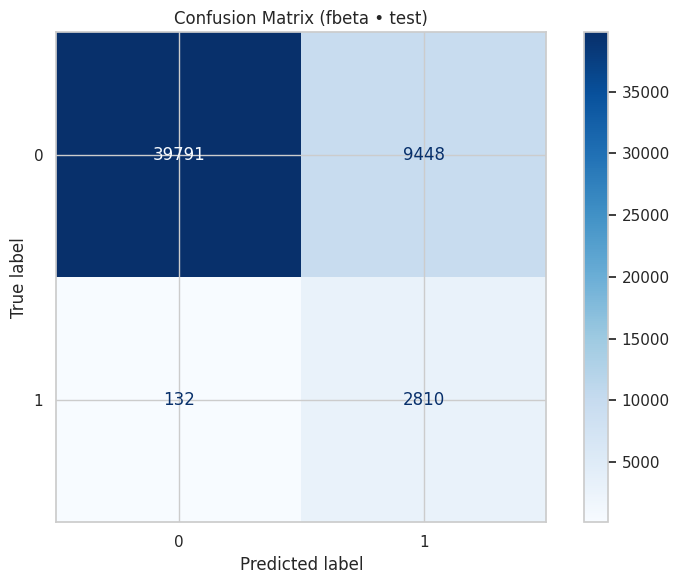

In [224]:
optuna.logging.set_verbosity(optuna.logging.INFO)
metrics = ["fbeta"]
best_models = {}

os.makedirs("../data", exist_ok=True)

for metric in metrics:
    print(f"\n Оптимизация по метрике: {metric}")
    study = optuna.create_study(direction="maximize")
    study.optimize(
        get_objective(metric),
        n_trials=5,
        timeout=3600,
        callbacks=[log_callback]
    )

    best_params = study.best_trial.params

    pipeline = make_pipeline(
        SimpleImputer(strategy="mean"),
        XGBClassifier(**best_params, objective="binary:logistic", eval_metric="logloss", n_jobs=-1)
    )
    pipeline.fit(X_train, y_train)

    val_probs = pipeline.predict_proba(X_valid)[:, 1]
    best_thr = find_threshold_for_fbeta(y_valid, val_probs)

    test_probs = pipeline.predict_proba(X_test)[:, 1]
    test_pred = (test_probs > best_thr).astype(int)

    print(f"\n[{metric}] ── Финальные метрики на TEST ──")
    print(f"Порог: {best_thr:.2f}")
    print(classification_report(y_test, test_pred))
    print("ROC AUC:", roc_auc_score(y_test, test_probs))

    cm = confusion_matrix(y_test, test_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])\
        .plot(cmap="Blues", values_format='d')
    plt.title(f"Confusion Matrix ({metric} • test)")
    plt.tight_layout(); plt.show()

    with open(f"../data/final_model_{metric}.pkl", "wb") as f:
        pickle.dump({"model": pipeline, "threshold": best_thr}, f)

    best_models[metric] = pipeline

              precision    recall  f1-score   support

           0       1.00      0.67      0.80     49239
           1       0.15      0.99      0.26      2942

    accuracy                           0.69     52181
   macro avg       0.58      0.83      0.53     52181
weighted avg       0.95      0.69      0.77     52181

ROC AUC: 0.945664588800897


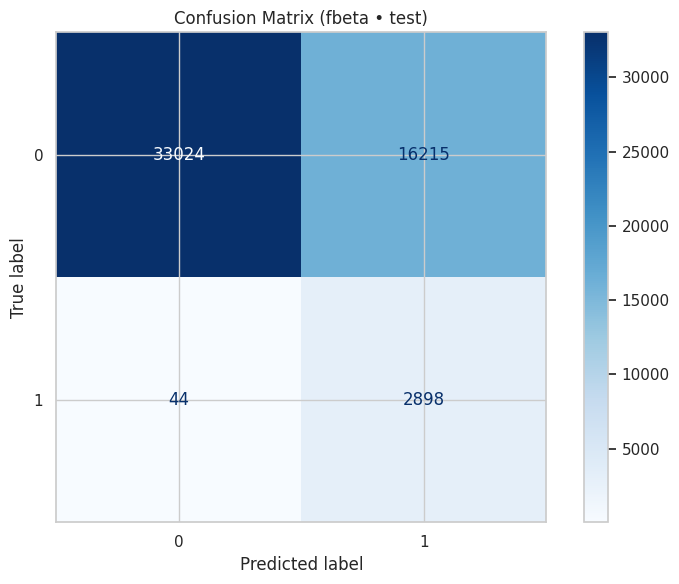

In [234]:
test_pred_highrecall = (test_probs > 0.1).astype(int)

print(classification_report(y_test, test_pred_highrecall))
print("ROC AUC:", roc_auc_score(y_test, test_probs))

cm = confusion_matrix(y_test, test_pred_highrecall)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])\
    .plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix (fbeta • test)")
plt.tight_layout(); plt.show()

--- FBETA ---
Порог: 0.32
 Параметры модели:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5989268509594416, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'feature_weights': None, 'gamma': 3.495713681744565, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.005216938248567469, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 2500, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': 5.309435536687509, 'reg_lambda': 6.418909487429637, 'sampling_method': None, 'scale_pos_weight': 17, 'subsample': 0.8297700533904776, 'tree_method': None, 

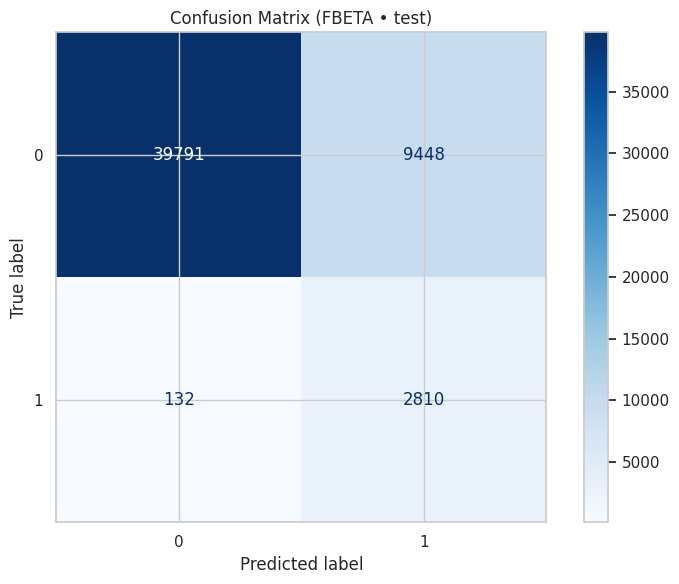

/tmp/ipykernel_61690/3575331226.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=fi_df.head(50), palette="viridis")


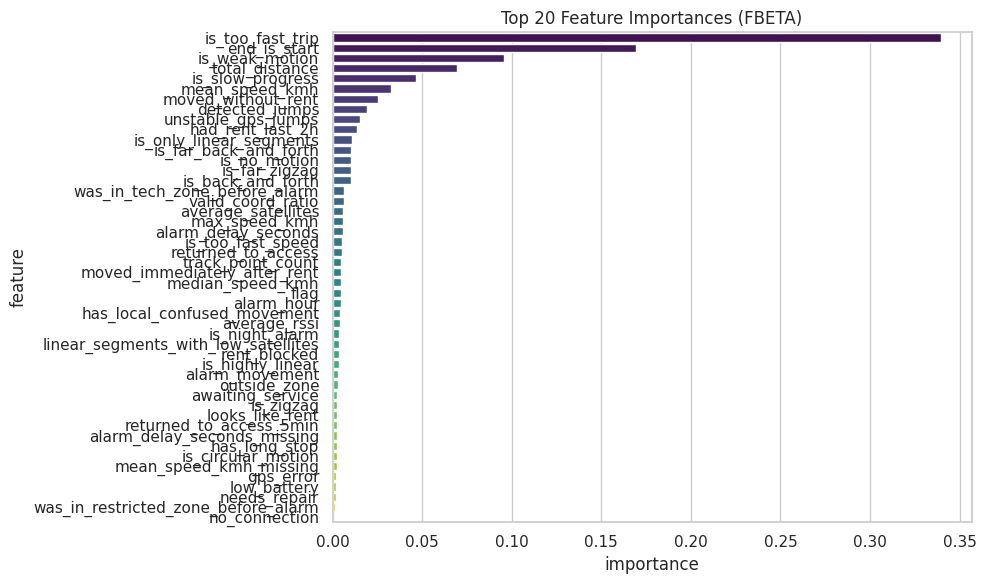

In [243]:
for metric in metrics:
    with open(f"../data/final_model_{metric}.pkl", "rb") as f:
        saved = pickle.load(f)
    
    model = saved["model"]
    threshold = saved["threshold"]

    print(f"--- {metric.upper()} ---")
    print(f"Порог: {threshold:.2f}")
    
    test_probs = model.predict_proba(X_test)[:, 1]
    test_pred = (test_probs > threshold).astype(int)

    print(" Параметры модели:")
    print(model.named_steps['xgbclassifier'].get_params())
    print()

    print(" Classification Report:")
    print(classification_report(y_test, test_pred))

    print(f" ROC AUC: {roc_auc_score(y_test, test_probs):.5f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, test_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])\
        .plot(cmap="Blues", values_format='d')
    plt.title(f"Confusion Matrix ({metric.upper()} • test)")
    plt.tight_layout()
    plt.show()

    # === Feature Importance Plot ===
    booster = model.named_steps["xgbclassifier"]
    feature_importance = booster.feature_importances_

    feature_names = X_train.columns
    fi_df = pd.DataFrame({
        "feature": feature_names,
        "importance": feature_importance
    }).sort_values(by="importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="importance", y="feature", data=fi_df.head(50), palette="viridis")
    plt.title(f"Top 20 Feature Importances ({metric.upper()})")
    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

best_params = {
     'n_estimators': 2500, 
     'max_depth': 6, 
     'learning_rate': 0.005216938248567469, 
     'subsample': 0.8297700533904776, 
     'colsample_bytree': 0.5989268509594416, 
     'gamma': 3.495713681744565, 
     'reg_alpha': 5.309435536687509, 
     'reg_lambda': 6.418909487429637, 
     'scale_pos_weight': 17, 
     'min_child_weight': 5
    }

model = XGBClassifier(**best_params)
model.fit(X_train, y_train)


## Save model

In [246]:
import pickle

with open("../models/model_xgb_02_05.pkl", "wb") as f:
    pickle.dump(model, f)

feature_list = X_train.columns.tolist()
with open("../data/xgb_features_02_05.txt", "w") as f:
    for feat in feature_list:
        f.write(feat + "\n")

In [ ]:
y_probs = model.predict_proba(X)[:, 1]
incident_ids['prediction'] = y_probs
incident_ids

In [ ]:
targets = [0.1 * i for i in range(1, 11)]
for t in targets:
    closest = incident_ids.iloc[(incident_ids['prediction'] - t).abs().argsort()[:2]]
    print(f"\n Ближайшие к {int(t*100)}%:")
    print(closest)

              precision    recall  f1-score   support

           0       1.00      0.67      0.80     49239
           1       0.15      0.99      0.26      2942

    accuracy                           0.69     52181
   macro avg       0.58      0.83      0.53     52181
weighted avg       0.95      0.69      0.77     52181

ROC AUC: 0.945664588800897


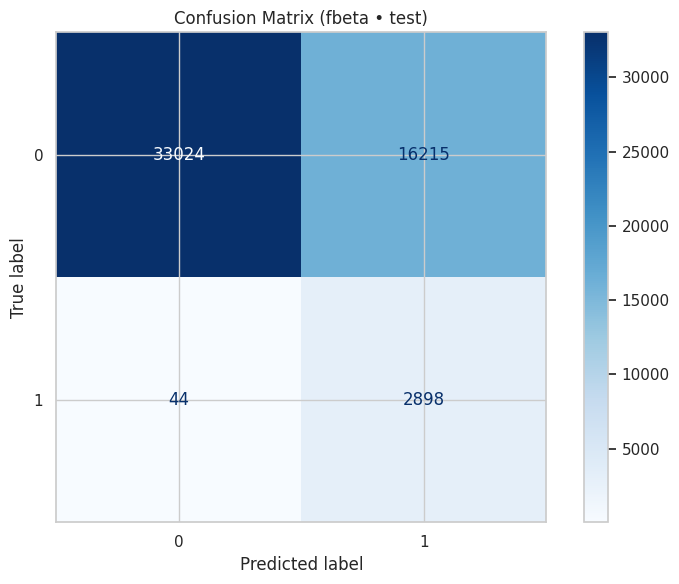

In [245]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Предсказание вероятностей для тестового набора
test_probs = model.predict_proba(X_test)[:, 1]

# Применение порога для классификации
test_pred_highrecall = (test_probs > 0.1).astype(int)

# Оценка модели
print(classification_report(y_test, test_pred_highrecall))
print("ROC AUC:", roc_auc_score(y_test, test_probs))

# Построение матрицы ошибок
cm = confusion_matrix(y_test, test_pred_highrecall)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])\
    .plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix (fbeta • test)")
plt.tight_layout()
plt.show()

In [199]:
print(y_train.value_counts(normalize=True))
print(y_valid.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

business_status
0    0.951167
1    0.048833
Name: proportion, dtype: float64
business_status
0    0.94508
1    0.05492
Name: proportion, dtype: float64
business_status
0    0.94128
1    0.05872
Name: proportion, dtype: float64
